## Making the most of pure parallels: Machine learning augmented photometric redshifts for sparse _JWST_ filter sets

### Kenneth Duncan


### Abstract

Photometric redshifts (photo-$z$s) are an essential tool for galaxy evolution science with _JWST_.
However, for deep surveys with more limited filter sets (i.e. $N_{\text{filt}} \sim6$) such as large pure parallel surveys, the most commonly used template-fitting based photo-$z$ approaches can yield highly confident but spurious results for high-$z$ populations of interest, potentially limiting the utility of these valuable datasets.
To address this challenge, we present a comprehensive study on the application of machine learning (ML) based photo-$z$ techniques to deep _JWST_ photometric datasets.
We employ two different ML approaches using Gaussian process and nearest-neighbour based algorithms, alongside a template fitting approach that is standard for high-$z$ studies.
We show that simple nearest-neighbour estimates can provide more accurate photo-$z$s than template fitting out to $z\sim8$, as well as reducing the fraction of catastrophic outliers by $\sim2-3$.
Additionally, `hybrid' estimates combining template and ML can yield further improvements in overall accuracy and reliability while retaining the ability to predict photo-$z$ out to $z > 10$. 
The nearest-neighbour only or hybrid estimates can achieve photo-$z$s with robust scatter of $\sigma_{\text{NMAD}}\sim0.03-0.04$ and outlier fractions of $\sim3-10\%$ between $0 < z \lesssim 8$ from just 6 NIRCam bands, with negligible additional computational costs compared to standard template fitting.
Our methodology is easily adaptable to alternative datasets or extended training samples, and highlights the potential for even simple ML techniques to enhance the scientific return of _JWST_ pure parallel and wide-area surveys.


## Overview

This notebook implements a **hierarchical Bayesian consensus photo-z pipeline** combining three complementary machine learning methods to estimate photometric redshifts for sparse JWST deep field observations:

1. **GPz** (Gaussian Process regression) - Non-parametric ML approach
2. **EAZY** (SED template fitting) - Physics-based template matching  
3. **NNz** (Nearest Neighbor) - Chi-squared weighted local averaging

### Methodology Highlights

This pipeline:
- Assembles multi-survey spectroscopic training data (CANDELS, JWST/NIRSpec, WFSS)
- Cross-matches spec-z samples to JWST photometry from DJA catalogs
- Applies galactic extinction correction using SFD dust maps
- Transforms fluxes to asinh magnitudes (luptitudes) for robust ML training
- Calibrates P(z) distributions to correct for overconfidence
- Combines methods via hierarchical Bayesian marginalization over catastrophic outlier fractions

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True


import os
import yaml

import numpy as np
import seaborn as sns

import glob
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, vstack
from astropy.stats import sigma_clipped_stats, mad_std, bootstrap
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.utils import NumpyRNGContext


from gpz_pype.utilities import Params, set_gpz_path, basic_lupt_soft, flux_to_lupt
from gpz_pype.base import GPz
from gpz_pype.gmm import GMMbasic

from tqdm import tqdm_notebook as tqdm

from scipy.stats import gaussian_kde
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from gpz4jwst_utils import *

def calc_HPDciv(pz, zgrid, specz):
    dz = np.diff(zgrid[:2])

    i_zspec = np.argmin((np.abs(specz[:,None] - zgrid[None,:])), axis=1)
    pz_s = pz[np.arange(len(i_zspec)), i_zspec]
    mask = (pz < pz_s[:, None])
    ipz_masked = np.copy(pz)
    ipz_masked[mask] *= 0.

    CI = np.trapezoid(ipz_masked, zgrid, axis=1) / np.trapezoid(pz, zgrid, axis=1)

    return CI
   
def calc_ci_dist(pz, zgrid, specz):
    ci_pdf = calc_HPDciv(pz, zgrid, specz)
    nbins = 100
    hist, bin_edges = np.histogram(ci_pdf, bins=nbins, range=(0,1), density=True)
    cumhist = np.cumsum(hist)/nbins
    bin_max = 0.5*(bin_edges[:-1]+bin_edges[1:])
    
    return cumhist, bin_max

---

## Part 1: Spectroscopic Training Sample Assembly

The quality of photometric redshift estimates depends critically on the **spectroscopic training sample**. For JWST deep fields, we assemble spec-z from multiple heterogeneous sources:

### Data Sources

1. **CANDELS HST Legacy**: High-confidence redshifts from 5 fields (GOODS-S, GOODS-N, EGS, UDS, COSMOS)
2. **JWST/NIRSpec**: High-quality redshifts from DJA v4.4 (grade=3 only)
3. **JWST/WFSS**: Emission line redshifts from FRESCO survey (H-alpha and [OIII] emitters) and ALT DR1 spectroscopic sample

### Key Considerations

- **Quality filtering**: Only grade=3 NIRSpec redshifts to ensure reliability
- **Redundancy removal**: Cross-match at 0.4" to avoid duplicate training examples
- **Prioritization**: NIRSpec > WFSS > Literature for overlapping sources
- **Grism supplementation**: CANDELS grism redshifts used where spec-z unavailable

This multi-source approach maximizes training sample size while maintaining quality control.

In [4]:
candels_speczs = []

candels_fields = ["goods-s", "goods-n", "egs", "uds", "cosmos"]

for field in candels_fields:
    print(field)
    file = f"hlsp_candels_hst_wfc3_{field.replace('-', '')}_multi_v2_redshift-cat.txt"
    
    if os.path.isfile(f"data/{file}"):
        c = Table.read(f"data/{file}", format='ascii')
    else:
        path = f"https://archive.stsci.edu/hlsps/candels/{field}/catalogs/v2/hlsp_candels_hst_wfc3_{field.replace('-', '')}_multi_v2_redshift-cat.txt"
        c = Table.read(path, format='ascii')  
        c.write(f"data/{file}", format='ascii')

    has_grism = (c['z_grism'] > 0)
    no_spec_z = np.invert(c['z_spec'] > 0)
    
    c['z_spec'][has_grism*no_spec_z] = c['z_grism'][has_grism*no_spec_z]
    
    keep = (c['z_spec'] > 0.01)
    
    candels_speczs.append(c[keep])
    
candels_speczs = vstack(candels_speczs)

candels_speczs['source'] = 'Lit.'

goods-s
goods-n
egs
uds
cosmos


In [5]:
jwst_specz = Table.read('data/dja_jwst_specz_v4.4.csv')

jwst_specz = jwst_specz[jwst_specz['grade'] == 3]
jwst_specz.keep_columns(['srcid', 'ra', 'dec', 'zfit', 'z', 'root'])
jwst_specz['source'] = 'JWST/NIRSpec'

jwst_specz['srcid'].name = 'ID'
jwst_specz['ra'].name = 'RA'
jwst_specz['dec'].name = 'DEC'
jwst_specz['z'].name = 'z_spec'

jwst_coord = SkyCoord(jwst_specz['RA'], jwst_specz['DEC'], unit='deg')


In [6]:
halpha = Table.read('data/FRESCO_HA_emitters_release_v1.txt', format='ascii.commented_header', header_start=12)
halpha = halpha[halpha['q_mean'] == 3]

halpha['id'].name = 'ID'
halpha['ra'].name = 'RA'
halpha['dec'].name = 'DEC'
halpha['z'].name = 'z_spec'
halpha_coord = SkyCoord(halpha['RA'], halpha['DEC'], unit='deg')

halpha.keep_columns(['ID', 'RA', 'DEC', 'z_spec'])
halpha['source'] = 'JWST/WFSS'

idx, d2d, d3d = halpha_coord.match_to_catalog_sky(jwst_coord)

nirspec_ha_match = (d2d < 0.4*u.arcsec)
nirspec_ha_new = np.invert(nirspec_ha_match)

In [7]:
oiii = Table.read('data/FRESCO_O3_emitters_release_v1.txt', format='ascii.commented_header')
oiii = oiii[oiii['q_mean'] == 3]

oiii['ID'] = np.array(2e6 + np.arange(len(oiii)), dtype='int')
oiii['ra'].name = 'RA'
oiii['dec'].name = 'DEC'
oiii['z'].name = 'z_spec'
oiii_coord = SkyCoord(oiii['RA'], oiii['DEC'], unit='deg')

oiii.keep_columns(['ID', 'RA', 'DEC', 'z_spec'])
oiii['source'] = 'JWST/WFSS'

idx, d2d, d3d = oiii_coord.match_to_catalog_sky(jwst_coord)

nirspec_oiii_match = (d2d < 0.4*u.arcsec)
nirspec_oiii_new = np.invert(nirspec_oiii_match)

In [8]:
alt = Table.read('data/ALT_DR1_public.fits')
alt['id'].name = 'ID'
alt['ra'].name = 'RA'
alt['dec'].name = 'DEC'
alt['z_ALT'].name = 'z_spec'
alt['source'] = 'JWST/WFSS'

alt_coord = SkyCoord(alt['RA'], alt['DEC'], unit='deg')

idx, d2d, d3d = alt_coord.match_to_catalog_sky(jwst_coord)

nirspec_alt_match = (d2d < 0.4*u.arcsec)
nirspec_alt_new = np.invert(nirspec_alt_match)

In [9]:
jwst_specz = vstack([jwst_specz, 
                     halpha[nirspec_ha_new], 
                     oiii[nirspec_oiii_new],
                     alt[nirspec_alt_new]])

---

## Part 2: Cross-Matching to JWST Photometry

With spectroscopic samples assembled, we now match to **JWST photometric catalogs** from the Dawn JWST Archive (DJA).

### Cross-Matching Strategy

- **Search radius**: 0.4 arcsec (conservative to avoid mis-matches in crowded fields)
- **Multiple fields**: 11 JWST fields including CEERS, GOODS, PRIMER-COSMOS, Abell2744
- **Coordinate matching**: Using `astropy.coordinates.SkyCoord.match_to_catalog_sky()`

### Photometric Data Structure

DJA catalogs provide:
- **Fluxes**: μJy units for 6 NIRCam filters (F115W, F150W, F200W, F277W, F356W, F444W)
- **Uncertainties**: Formal photometric errors + RMS background estimates
- **Morphology**: Source sizes (radius) for optional morphological features

This cross-matching creates the **fundamental training catalog** linking spec-z to JWST photometry.

In [10]:
candels_coord = SkyCoord(candels_speczs['RA'], candels_speczs['DEC'], unit='deg')
jwst_coord = SkyCoord(jwst_specz['RA'], jwst_specz['DEC'], unit='deg')

idx, d2d, d3d = candels_coord.match_to_catalog_sky(jwst_coord)

match = (d2d < 0.4*u.arcsec)
no_match = np.invert(match)

merged_zs = vstack([candels_speczs[no_match], jwst_specz])
merged_zs.write('data/candels_jwst_specz_sample.fits', format='fits', overwrite=True)

In [11]:
cat_list = Table.read('data/dja_cat_list.csv')

for ic, path in tqdm(enumerate(cat_list['download'])):
    print(path)

    if not os.path.isfile(f'data/dja_cats/{cat_list["file"][ic]}'):
        cat = Table.read(path)
        cat.write(f'data/dja_cats/{cat_list["file"][ic]}', overwrite=True)

0it [00:00, ?it/s]

https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/abell2744clu-grizli-v7.2-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/abell2744par-grizli-v7.0-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/ceers-full-grizli-v7.4-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/gdn-grizli-v7.4-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/gds-grizli-v7.2-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/ngdeep-grizli-v7.2-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/primer-cosmos-east-grizli-v7.4-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/primer-cosmos-west-grizli-v7.4-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/primer-uds-north-grizli-v7.2-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/primer-uds-south-grizli-v7.2-fix_phot.fits
https://s3.amazonaws.com/grizli-v2/JwstMosaics/v7/abells1063-grizli-v7.5-fix_phot.fits


---

## Part 3: Galactic Extinction Correction & Flux Transformations

### Galactic Extinction Correction

Before training photo-z models, we must correct for **foreground Milky Way dust extinction**:

1. Query **SFD dust maps** (Schlegel, Finkbeiner & Davis 1998) for E(B-V) at each source position
2. Apply **Fitzpatrick99 extinction curve** appropriate for each NIRCam filter
3. Deredden fluxes: `F_corrected = F_observed × 10^(A_λ × E(B-V) / 2.5)`

### Luptitude Transformation

Standard magnitudes become problematic for faint/negative fluxes. We instead use **asinh magnitudes** (luptitudes):

```
lupt = -2.5/ln(10) × asinh((f/f₀) / (2b)) + m₀
```

where:
- `b` = softening parameter (set by RMS noise per filter)
- `f₀` = reference flux (3631 Jy)
- Smoothly transitions from linear (low S/N) to logarithmic (high S/N)

**Benefits**:
- Well-defined for negative fluxes (Gaussian errors)
- Preserves information from non-detections
- Reduces impact of outlier measurements

### Quality Cuts

Sources with `check_nans == 0` (no NaN luptitudes) and `0 < z_spec < 15` form the final training sample.

In [12]:
cat_list = Table.read('data/dja_cat_list.csv')

filts = ['f115w', 'f150w','f200w', 'f277w', 'f356w', 'f444w']

ap = '1'

catalogue_list = []

for ic, path in tqdm(enumerate(cat_list['file'])):
    try:
        cat = Table.read(f'data/dja_cats/{path}')    
        catp = Table()
        catp['ID'] = (ic+1)*1e7 + cat['id']
        field = '-'.join(cat_list['file'][ic].split('-')[:-3])
        print(field)
        catp['FIELD'] = field
        catp['RA'] = cat['ra']
        catp['DEC'] = cat['dec']
        catp['radius'] = cat['flux_radius']*0.04 # 0.04 arcsec pix LW
        catp['flux_radius_90'] = cat['flux_radius_90']*0.04
        catp['kron_rcirc'] = cat['kron_rcirc']*0.04
        catp['tot_corr'] = cat['tot_corr']
        catp['flux_radius_flag'] = cat['flux_radius_flag']

        corr = cat['flux_auto']/cat[f'flux_aper_{ap}']        
        
        flags = np.zeros(len(catp))
        
        for fx, filt in enumerate(filts[:]):
            has_flag = (cat[f'{filt}_flag_aper_{ap}'].filled(100) >= 8.)
            no_flag = np.invert(has_flag)
            try:
                catp[f'{filt}_flux'] = cat[f'{filt}_flux_aper_{ap}'].filled(np.nan)*corr
                rms = sigma_clipped_stats(cat[f'{filt}_bkg_aper_{ap}'][no_flag], 
                                        mask=np.isnan(cat[f'{filt}_bkg_aper_{ap}'].filled(np.nan)[no_flag]))[-1]

            except:
                catp[f'{filt}_flux'] = cat[f'{filt}_flux_aper_{ap}']*corr
                rms = sigma_clipped_stats(cat[f'{filt}_bkg_aper_{ap}'][no_flag], 
                                      mask=np.isnan(cat[f'{filt}_bkg_aper_{ap}'][no_flag]))[-1]

            catp[f'{filt}_fluxerr'] = np.sqrt((cat[f'{filt}_fluxerr_aper_{ap}']*corr)**2)
            catp[f'{filt}_rms'] = rms

            flags += has_flag
        
        keep = (flags == 0) * (cat['flux_radius'] != 0)
        
        catalogue_list.append(catp[keep])
    except:
        raise
        #continue
        
photom = vstack(catalogue_list)

0it [00:00, ?it/s]

abell2744clu
abell2744par
ceers-full
gdn
gds
ngdeep
primer-cosmos-east
primer-cosmos-west
primer-uds-north
primer-uds-south
abells1063


In [14]:
photom_coord = SkyCoord(photom['RA'], photom['DEC'], unit='deg')
specz_coord = SkyCoord(merged_zs['RA'], merged_zs['DEC'], unit='deg')

idx, d2d, d3d = photom_coord.match_to_catalog_sky(specz_coord)
match = (d2d < 0.4*u.arcsec)
        
photom['z_spec'] = np.ones(len(photom))*np.nan
photom['z_spec'][match] = merged_zs[idx[match]]['z_spec']
photom['source'] = np.array(['']*len(photom), dtype='S32')
photom['source'][match] = merged_zs[idx[match]]['source']

photom = ebv_corr(photom, filts)

f115w
f150w
f200w
f277w
f356w
f444w


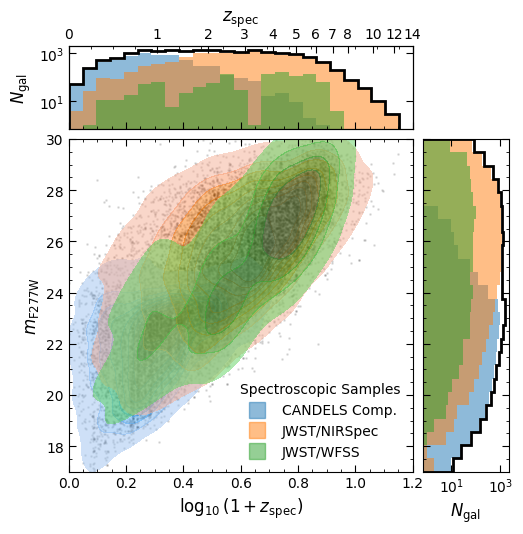

In [15]:
merged = photom[photom['z_spec'] > 0.]

lit = (merged['source'] == 'Lit.')
jwst = (merged['source'] == 'JWST/NIRSpec')
grism = (merged['source'] == 'JWST/WFSS')

fig = plt.figure(layout='constrained', figsize=(5.5,5.2))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.03, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.03, 0, 0.25, 1], sharey=ax)
# Draw the scatter plot and marginals.

zeta = np.log10(1+merged['z_spec'])

ax_histx.hist(zeta[lit], range=(0, 1.2), bins=25, alpha=0.5, label='CANDELS Comp.')
ax_histx.hist(zeta[jwst], range=(0, 1.2), bins=25, alpha=0.5, label='JWST/NIRSpec')
ax_histx.hist(zeta[grism], range=(0, 1.2), bins=25, alpha=0.5, label='JWST/WFSS')
ax_histx.hist(zeta, range=(0, 1.2), bins=25, histtype='step', lw=2, log=True, label='All', color='k')

mag = 23.9 - 2.5*np.log10(merged['f277w_flux'])

ax_histy.hist(mag[lit], range=(17, 30), bins=25, alpha=0.5, label='CANDELS Comp.', orientation='horizontal')
ax_histy.hist(mag[jwst], range=(17,30), bins=25, alpha=0.5, label='JWST/NIRSpec', orientation='horizontal')
ax_histy.hist(mag[grism], range=(17, 30), bins=25, alpha=0.5, label='JWST/WFSS', orientation='horizontal')
ax_histy.hist(mag, range=(17, 30), bins=25, histtype='step', lw=2, log=True, label='All', color='k', orientation='horizontal')

#Leg = Ax.legend(loc='upper right', frameon=False)
ax_histy.set_xlabel(r'$N_{\rm{gal}}$', size=12)

#ax_histx.set_ylim([0.2, 1e4])
ax_histx.set_ylabel(r'$N_{\rm{gal}}$', size=12)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.scatter(zeta, mag, s=1, alpha=0.1, color='k', rasterized=True)

tw = ax_histx.twiny()
tw.set_xticks(np.log10(1+np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14])))
tw.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14])
tw.set_xlabel(r'$z_{\rm{spec}}$', size=12)

sns.kdeplot(x=zeta[lit], y=mag[lit], ax=ax, fill=True, alpha=0.5, thresh=0.025)
sns.kdeplot(x=zeta[jwst], y=mag[jwst], ax=ax, fill=True, alpha=0.5, thresh=0.025)
sns.kdeplot(x=zeta[grism], y=mag[grism], ax=ax, fill=True, alpha=0.5, thresh=0.05, levels=5)

ax.plot(-1, -1, 's', ms=12, alpha=0.5, label='CANDELS Comp.')
ax.plot(-1, -1, 's', ms=12, alpha=0.5, label='JWST/NIRSpec')
ax.plot(-1, -1, 's', ms=12, alpha=0.5, label='JWST/WFSS')

leg = ax.legend(loc='lower right', frameon=False)
leg.set_title('Spectroscopic Samples', prop={'size':10})

ax.set_xlim([0, 1.2])
ax.set_ylim([17, 30])
ax.set_ylabel(r'$m_{\rm{F277W}}$', size=12)
ax.set_xlabel(r'$\log_{10}(1+z_{\rm{spec}})$', size=12)

fig.tight_layout()
fig.savefig('figures/training_sample_mag_v_z.pdf', format='pdf', bbox_inches='tight')

---

## Part 4: Method 1 - GPz (Gaussian Process Regression)

### What is GPz?

**GPz** (Almosallam et al. 2016) uses **sparse Gaussian Process regression** to learn the complex, non-linear mapping from photometry to redshift:

- **Non-parametric**: Makes no assumptions about functional form of color-redshift relations
- **Heteroscedastic**: Models both aleatoric (measurement) and epistemic (model) uncertainty
- **Sparse approximation**: Uses basis functions to scale to large datasets

### GPz Implementation

We first set up othe necessary paths to run GPz using the [gpz_pype](https://dunkenj.github.io/gpz_pype/) package. Instructions for installation of the underlying `gpz++` C++ package and `gpz_pype` can be found through the link. 

For data security, we here set the path to `gpz++` using an additional environment variable. But this can be set manually. Next we instatiate the main `GPz` class with the example parameter file in a similar way before generating an output folder for `gpz++` to save intermediate catalogue files and model parameters etc.

### Key Hyperparameters

1. **Number of basis functions (NUM_BF)**: Controls model complexity
   - Too few → underfitting (high bias)
   - Too many → overfitting / local minima
   - Optimal: ~75 for our sample size (~1000 objects)

2. **Covariance structure**: 'gpvd' (global, point-wise, variable, diagonal)
   - Allows uncertainty to vary across color space
   - Computationally efficient for our sample sizes

3. **Weighting scheme**: 'uniform' vs 'balanced' vs '1/(1+z)'
   - Uniform: Weight all training examples equally
   - Balanced: Compensate for redshift distribution in training set

### Training/Validation Split

- **70% training**: Used to fit GP hyperparameters
- **20% validation**: Prevent overfitting during optimization
- **10% test**: Final performance evaluation (held out from all training)

**Critical**: Use `random_seed=1234` for reproducibility across runs.

In [16]:
set_gpz_path(os.getenv('GPZROOT')+'bin/gpz++')

gpz = GPz(param_file=os.getenv('GPZROOT')+'example/gpz.param', ncpu=8)
gpz.params['REUSE_MODEL'] = '0'
gpz.params['WEIGHTING_SCHEME'] = 'uniform' # 'balanced' / '1/(1+z)' 
gpz.params['BALANCED_WEIGHTING_BIN'] = 1

outdir = 'default' 

if not os.path.isdir(outdir):
    os.mkdir(outdir)

## Choosing an optimal number of basis functions

Given the limited sample sizes and the efficiency of GPz, training times even for large numbers of GP basis functions (e.g. ~500) using the default suggested covariance (global diagonal covariance, 'gpvd' in Almosallam+2015) are relatively trivial on just a laptop. Nevertheless, we still want to only employ the number of basis functions necessary to provide accurate/generalised results while avoiding over-fitting or the optimisation getting stuck in very local minima.

For a simple GPz optimisation using only the fiducial filter set, we therefore explore how the general photo-z statistics scale as a function of $N_{\rm BF}$ (NUMBF in the gpz++ params).

In [17]:
# Make a new catalogue with the relevant key reference columns:
lupt_cols = photom[['ID', 'RA', 'DEC', 'z_spec']]

check_nans = np.zeros(len(photom)) # Running counter of null values for each object

for filt in filts:
    lupt, lupterr = flux_to_lupt(photom[f'{filt}_flux'].filled(np.nan), # Input flux (uJy)
                                 photom[f'{filt}_fluxerr'].filled(np.nan), # Input uncertainty (uJy)
                                 (photom[f'{filt}_rms']/1e6)/3631, # Filter specific softening parameter
                                ) 
    
    lupt_cols[f'lupt_{filt}'] = lupt
    lupt_cols[f'lupterr_{filt}'] = lupterr
    
    check_nans += np.isnan(lupt) # Update nan counter for this filter
    check_nans += np.isnan(lupterr) # Update nan counter for this filter

good = (check_nans == 0) # 'Good' sources for training are those with 0 NaNs

zcut = np.logical_and(photom['z_spec'] > 0, photom['z_spec'] < 15)
cat = lupt_cols[good * zcut] # Keep only good sources with z_spec

bf_range = np.concatenate([np.arange(10, 151, 10)]) # Range of basis functions to explore

bf_stats = []

cat = cat[shuffle(np.arange(len(cat)))] # Manually shuffle the training catalogue

for num_bf in tqdm(bf_range):
    simple_run, paths = gpz.run_training(
          cat, # Run training on this input catalogue - can be a path or a Table object
          outdir=outdir, # Save training/output catalogues in this directory
          basename='jwst_gpz_basic', # Start our output filenames with this
          bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
          mag_prefix='lupt_', # Look for these asinh magnitude columns
          error_prefix='lupterr_', # Look for these error columns
          id_col='ID', # ID column to propagate into output files
          total_basis_functions=num_bf, # NUMBF passed to gpz++
          do_iteration=False, # If True, run second iteration with more complex covariance
          verbose=False, # Don't print all of the gpz++ output to screen. Turn on for debugging
          test_fraction=0.1, # Keep 10% reserved for test sample
          valid_fraction=0.2, # Use 20% of the total sample for validation (to prevent overfitting)
          train_test_shuffle=False, # Do not reshuffle the train/test split
          output_max=15,
          random_seed=1234, # Set a random seed for reproducibility
        )
    
    # Bootstrap statistics for any sample variance on the derived statistics
    # Underlying variance in the random training + test splits likely to dominate
    boot_samples = np.array(bootstrap(np.arange(len(simple_run)), bootnum=100), dtype=np.int32)

    bst = []
    for s in boot_samples:
        bst.append(calcStats(simple_run['z_spec'][s], simple_run['value'][s]))
    bst = np.array(bst)
        
    bf_stats.append(np.percentile(bst, [16, 50, 84], axis=0))

bf_stats = np.array(bf_stats)

  0%|          | 0/15 [00:00<?, ?it/s]

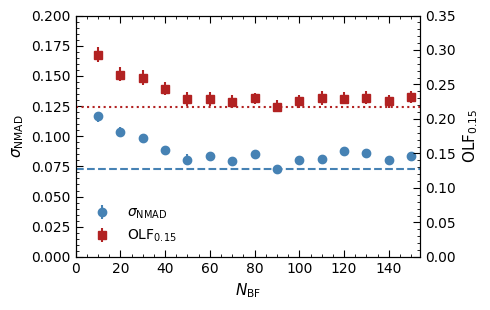

In [18]:
Fig, Ax = plt.subplots(1,1, figsize=(5,3.2))

Ax.errorbar(bf_range, bf_stats[:, 1, 0], 
             yerr=[bf_stats[:, 1, 0]-bf_stats[:, 0, 0],
                   bf_stats[:, 2, 0]-bf_stats[:, 1, 0]],
             fmt='o', color='steelblue', label=r'$\sigma_{\rm{NMAD}}$')
Ax.plot([0, 500], np.ones_like([0, 500]) * bf_stats[:, 1, 0].min(), '--', color='steelblue')
Ax.set_ylim([0.0, 0.2])
Ax.set_xlim([0, 154])
Ax.set_ylabel(r'$\sigma_{\rm{NMAD}}$', size=11)
Ax.set_xlabel(r'$N_{\rm{BF}}$', size=11)

Tw = Ax.twinx()
Tw.errorbar(bf_range, bf_stats[:, 1, 1], 
             yerr=[bf_stats[:, 1, 1]-bf_stats[:, 0, 1],
                   bf_stats[:, 2, 1]-bf_stats[:, 1, 1]],
             fmt='s', color='firebrick', label=r'$\rm{OLF}_{0.15}$')
Tw.plot([0, 500], np.ones_like([0, 500]) * bf_stats[:, 1, 1].min(), ':', color='firebrick')
Tw.set_ylim([0.0, 0.35])
Tw.set_xlim([0, 154])
Tw.set_ylabel(r'$\rm{OLF}_{0.15}$', size=11)

l1, lab1 = Ax.get_legend_handles_labels()
l2, lab2 = Tw.get_legend_handles_labels()

Leg = Ax.legend(l1+l2, lab1+lab2, loc='lower left', frameon=False)

Fig.tight_layout()
Fig.savefig('figures/stats_vs_nbf.pdf', format='pdf', bbox_inches='tight')


In [19]:
# Make a new catalogue with the relevant key reference columns:
lupt_cols = photom[['ID', 'RA', 'DEC', 'z_spec']]

check_nans = np.zeros(len(photom)) # Running counter of null values for each object

for filt in filts:
    lupt, lupterr = flux_to_lupt(photom[f'{filt}_flux'].filled(np.nan), # Input flux (uJy)
                                 photom[f'{filt}_fluxerr'].filled(np.nan), # Input uncertainty (uJy)
                                 (photom[f'{filt}_rms']/1e6)/3631, # Filter specific softening parameter
                                ) 
    
    lupt_cols[f'lupt_{filt}'] = lupt
    lupt_cols[f'lupterr_{filt}'] = lupterr
    
    check_nans += np.isnan(lupt) # Update nan counter for this filter
    check_nans += np.isnan(lupterr) # Update nan counter for this filter

# lupt_cols['lupt_s'] = radius
# lupt_cols['lupterr_s'] = radius_err

# check_nans += np.isnan(radius)
# check_nans += np.isnan(radius_err)

good = (check_nans == 0) # 'Good' sources for training are those with 0 NaNs

zcut = np.logical_and(photom['z_spec'] > 0, photom['z_spec'] < 15)
cat = lupt_cols[good * zcut] # Keep only good sources with z_spec

simple_run, paths = gpz.run_training(
      cat, # Run training on this input catalogue - can be a path or a Table object
      outdir=outdir, # Save training/output catalogues in this directory
      basename='jwst_gpz_basic', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt_', # Look for these asinh magnitude columns
      error_prefix='lupterr_', # Look for these error columns
      id_col='ID', # ID column to propagate into output files
      total_basis_functions=75, # NUMBF passed to gpz++
      do_iteration=False, # If True, run second iteration with more complex covariance
      verbose=False, # Don't print all of the gpz++ output to screen. Turn on for debugging
      test_fraction=0.1,
      valid_fraction=0.2,
      output_max=15,
      random_seed=1234, # Set a random seed for reproducibility
    )

### Evaluating GPz Performance

Standard photo-z metrics used throughout:

1. **σ_NMAD** (Normalized Median Absolute Deviation):
   ```
   σ_NMAD = 1.48 × median(|Δz - median(Δz)| / (1+z_spec))
   ```
   - Robust to outliers (uses median instead of mean)
   - Typical target: σ_NMAD < 0.05 for high-quality photo-z

2. **OLF₀.₁₅** (Outlier Fraction):
   ```
   Fraction with |Δz|/(1+z_spec) > 0.15
   ```
   - Measures catastrophic failures
   - Goal: OLF < 5-10%

3. **Bias**:
   ```
   median(Δz / (1+z_spec))
   ```
   - Systematic offset from truth

### Magnitude Cuts

Statistics reported for `m_F444W < 27.5` to ensure reliable measurements at depth where training sample is more complete, but also for consistency of comparisons with [Williams et al. 2025](https://ui.adsabs.harvard.edu/abs/2025ApJ...979..140W).

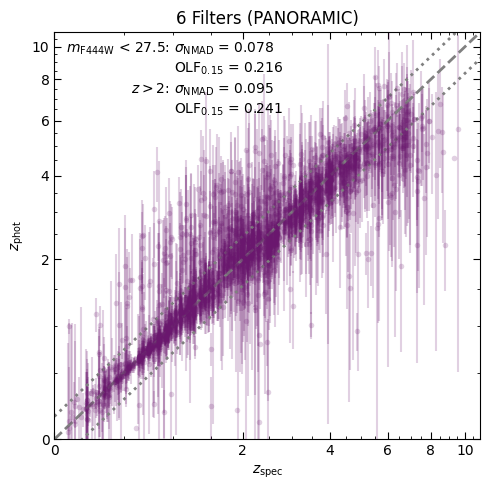

In [20]:
Fig, Ax = plt.subplots(1, 1, figsize=(5, 5))

c = plt.cm.inferno(0.3)

Ax.errorbar(simple_run['z_spec'], simple_run['value'], 
            yerr=simple_run['uncertainty'], mew=0, 
            fmt='o', ms=4, color=c, ecolor=c, alpha=0.2)
Ax.set_xlim([0, 11])
Ax.set_ylim([0, 11])

Ax.set_yscale('function', functions=(forward, inverse))
Ax.set_xscale('function', functions=(forward, inverse))

mcut = (simple_run['lupt_f444w'] < 27.5)
stats_simple = calcStats(simple_run['z_spec'][mcut], simple_run['value'][mcut])

zcut = (simple_run['z_spec'] > 2)
stats_z = calcStats(simple_run['z_spec'][zcut*mcut], simple_run['value'][zcut*mcut])

sigma = r'$\sigma_{\rm{NMAD}}$'
olf = r'OLF$_{0.15}$'

Ax.text(0.27, 0.95, r'$m_{\rm{F444W}}$ < 27.5:', ha='right', transform=Ax.transAxes)
Ax.text(0.28, 0.95, f'{sigma} = {stats_simple[0]:.3f}', ha='left', transform=Ax.transAxes)
Ax.text(0.28, 0.9, f'{olf} = {stats_simple[1]:.3f}', ha='left', transform=Ax.transAxes)

Ax.text(0.27, 0.85, r'$z > 2$:', ha='right', transform=Ax.transAxes)
Ax.text(0.28, 0.85, f'{sigma} = {stats_z[0]:.3f}', ha='left', transform=Ax.transAxes)
Ax.text(0.28, 0.8, f'{olf} = {stats_z[1]:.3f}', ha='left', transform=Ax.transAxes)

zrange = np.linspace(0, 12, 100)
Ax.plot([0, 14], [0, 14], '--', color='0.5', lw=2)
Ax.plot(zrange, zrange+(0.15*(1+zrange)), ':', color='0.5', lw=2)
Ax.plot(zrange, zrange-(0.15*(1+zrange)), ':', color='0.5', lw=2)


Ax.set_xlabel(r'$z_{\rm{spec}}$')
Ax.set_ylabel(r'$z_{\rm{phot}}$')
Ax.set_title('6 Filters (PANORAMIC)')
Fig.tight_layout()
Fig.savefig('figures/gpz4jwst_basic_panoramic6_zspec_comp.pdf', format='pdf', bbox_inches='tight')

In [21]:
# Make a new catalogue with the relevant key reference columns:
lupt_cols = photom[['ID', 'RA', 'DEC', 'z_spec']]

check_nans = np.zeros(len(photom)) # Running counter of null values for each object

for filt in filts:
    lupt, lupterr = flux_to_lupt(photom[f'{filt}_flux'].filled(np.nan), # Input flux (uJy)
                                 photom[f'{filt}_fluxerr'].filled(np.nan), # Input uncertainty (uJy)
                                 (photom[f'{filt}_rms']/1e6)/3631, # Filter specific softening parameter
                                ) 
    
    lupt_cols[f'lupt_{filt}'] = lupt
    lupt_cols[f'lupterr_{filt}'] = lupterr
    
    check_nans += np.isnan(lupt) # Update nan counter for this filter
    check_nans += np.isnan(lupterr) # Update nan counter for this filter

lupt_cols['lupt_s'] = photom['radius']
lupt_cols['lupterr_s'] = photom['radius']*0.05

check_nans += np.isnan(photom['radius'])

good = (check_nans == 0) # 'Good' sources for training are those with 0 NaNs

zcut = np.logical_and(photom['z_spec'] > 0, photom['z_spec'] < 15)
cat = lupt_cols[good * zcut] # Keep only good sources with z_spec


size_run, paths = gpz.run_training(
      cat, # Run training on this input catalogue - can be a path or a Table object
      outdir=outdir, # Save training/output catalogues in this directory
      basename='jwst_gpz_basic_size', # Start our output filenames with this
      bash_script=False, # Run GPz directly, don't just write the parameter files + commands to bash
      mag_prefix='lupt_', # Look for these asinh magnitude columns
      error_prefix='lupterr_', # Look for these error columns
      id_col='ID', # ID column to propagate into output files
      total_basis_functions=75, # NUMBF passed to gpz++
      do_iteration=False, # If True, run second iteration with more complex covariance
      verbose=False,# Don't print all of the gpz++ output to screen. Turn on for debugging
      test_fraction=0.1, # Keep 10% reserved for test sample
      valid_fraction=0.2, # Use 20% of the total sample for validation (to prevent overfitting)
      output_max=15, # Maximum redshift to output
      random_seed=1234, # Set a random seed for reproducibility
    )

### Adding Morphological Information

Photo-z accuracy can potentially be improved by including **morphological features** alongside colors:

- **Galaxy size** (radius) correlates with redshift at fixed magnitude
- Compact sources more likely to be high-z
- Extended sources more likely to be low-z star-forming galaxies

We augment the feature vector with:
```python
lupt_cols['lupt_s'] = radius  # Luptitude-scaled size
lupt_cols['lupterr_s'] = radius * 0.05  # 5% systematic uncertainty
```


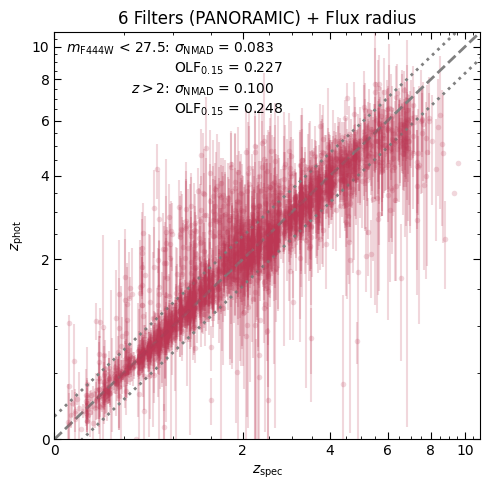

In [22]:
# Function x**(1/2)
def forward(x):
    return np.log10(1+x)

def inverse(x):
    return (10**x) - 1

c = plt.cm.inferno(0.5)

Fig, Ax = plt.subplots(1, 1, figsize=(5, 5))

Ax.errorbar(size_run['z_spec'], size_run['value'], 
            yerr=size_run['uncertainty'], mew=0, 
            fmt='o', ms=4, color=c, ecolor=c, alpha=0.2)
Ax.set_xlim([0, 11])
Ax.set_ylim([0, 11])

Ax.set_yscale('function', functions=(forward, inverse))
Ax.set_xscale('function', functions=(forward, inverse))

mcut = (size_run['lupt_f444w'] < 27.5)
stats_simple = calcStats(size_run['z_spec'][mcut], size_run['value'][mcut])

zcut = (size_run['z_spec'] > 2)
stats_z = calcStats(size_run['z_spec'][zcut*mcut], size_run['value'][zcut*mcut])

sigma = r'$\sigma_{\rm{NMAD}}$'
olf = r'OLF$_{0.15}$'

Ax.text(0.27, 0.95, r'$m_{\rm{F444W}}$ < 27.5:', ha='right', transform=Ax.transAxes)
Ax.text(0.28, 0.95, f'{sigma} = {stats_simple[0]:.3f}', ha='left', transform=Ax.transAxes)
Ax.text(0.28, 0.9, f'{olf} = {stats_simple[1]:.3f}', ha='left', transform=Ax.transAxes)

Ax.text(0.27, 0.85, r'$z > 2$:', ha='right', transform=Ax.transAxes)
Ax.text(0.28, 0.85, f'{sigma} = {stats_z[0]:.3f}', ha='left', transform=Ax.transAxes)
Ax.text(0.28, 0.8, f'{olf} = {stats_z[1]:.3f}', ha='left', transform=Ax.transAxes)

zrange = np.linspace(0, 12, 100)
Ax.plot([0, 14], [0, 14], '--', color='0.5', lw=2)
Ax.plot(zrange, zrange+(0.15*(1+zrange)), ':', color='0.5', lw=2)
Ax.plot(zrange, zrange-(0.15*(1+zrange)), ':', color='0.5', lw=2)

Ax.set_xlabel(r'$z_{\rm{spec}}$')
Ax.set_ylabel(r'$z_{\rm{phot}}$')
Ax.set_title('6 Filters (PANORAMIC) + Flux radius')
Fig.tight_layout()
Fig.savefig('figures/gpz4jwst_basic_panoramic6_wsize_zspec_comp.pdf', format='pdf', bbox_inches='tight')

# EAzY Template Photo-z Estimation


---

## Part 5: Method 2 - EAZY (Template-Based SED Fitting)


### Zero-Point Calibrations

Template-based methods require **photometric zero-point offsets** to account for systematic differences between catalogs:

```python
pz.zp = [0.876, 0.871, 0.903, 1.0, 1.077, 1.148]  # Per filter
```

These are derived from DJA analysis and ensure consistency with observed colors.

In [27]:
import eazy.photoz

# Symlink templates & filters from the eazy-code repository
try:
    print('EAZYCODE = '+os.getenv('EAZYCODE'))
except:
    pass

if not os.path.exists('templates'):
    eazy.symlink_eazy_inputs() 

merged.write('default/jwst_gpz_basic_foreazy.txt', format='ascii.commented_header', overwrite=True)

EAZYCODE = Users/duncan/Astro/code/eazy-py/eazy-photoz


Cloning into 'eazy-photoz'...


cloning https://github.com/gbrammer/eazy-photoz.git to Users/duncan/Astro/code/eazy-py
Users/duncan/Astro/code/eazy-py/eazy-photoz/templates -> ./templates
Users/duncan/Astro/code/eazy-py/eazy-photoz/filters/FILTER.RES.latest -> ./FILTER.RES.latest


In [28]:
template_sets = ['templates/sfhz/agn_blue_sfhz_13.param']
                # 'templates/eazy_v1.3.spectra.param',
                # 'templates/tweak_fsps_QSF_12_v3_newtemplates_Lya_Reduced.param', 

pzruns = []

for i, templates in enumerate(template_sets[:]):
    params = {}
    params['CATALOG_FILE'] = 'default/jwst_gpz_basic_foreazy.txt'

    params['MAIN_OUTPUT_FILE'] = 'jwst_gpz_eazy'

    # Galactic extinction
    params['MW_EBV'] = 0.00
    params['CAT_HAS_EXTCORR'] = True

    params['Z_STEP'] = 0.003
    params['Z_MIN'] = 0.01
    params['Z_MAX'] = 15.
    params['Z_STEP_TYPE'] = 1

    params['SYS_ERR'] = 0.05
    params['TEMP_ERR_A2'] = 0.0
    params['APPLY_PRIOR'] = 'N'
    params['PRIOR_FILTER'] = 380
    params['PRIOR_ABZP'] = 23.9 
    params['PRIOR_FILE'] = ''

    params['TEMPLATES_FILE'] = os.path.join('/', os.getenv('EAZYCODE'), templates)
    params['FIX_ZSPEC'] = False
    params['TEMP_ERR_FILE'] = os.path.join('/', os.getenv('EAZYCODE'), 'templates/uvista_nmf/template_error_10.def')

    params['IGM_SCALE_TAU'] = 1.0

    translate_file = os.path.join(os.getenv('EAZYCODE'), 'inputs/zphot.translate')


    translate = Table()
    filtcols = [col for col in merged.colnames if col.find('_flux') != -1]
    translate['filt'] = ['ID', 'z_spec'] + filtcols
    translate['num'] = ['id', 'z_spec',
                        'F364', 'E364',
                        'F365', 'E365',
                        'F366', 'E366',
                        'F375', 'E375',
                        'F376', 'E376',
                        'F377', 'E377',
                       ]


    translate_file = os.path.join('/', os.getenv('EAZYCODE'), 'inputs/zphot.translate')

    translate.write(translate_file, format='ascii.no_header', overwrite=True)

    params['FIX_ZSPEC'] = False

    pz = eazy.photoz.PhotoZ(param_file=None, translate_file=translate_file, 
                            zeropoint_file=None, 
                            params=params, 
                            load_prior=True, load_products=False)

    pz.zp = [0.876, 0.871, 0.903, 1.0, 1.077, 1.148] # From DJA - for consistency

    # fit_parallel renamed to fit_catalog 14 May 2021
    pz.fit_catalog(pz.idx, n_proc=8)
    
    pzruns.append(pz)

Read default param file: /opt/anaconda3/envs/py312/lib/python3.12/site-packages/eazy/data/zphot.param.default
Read CATALOG_FILE: default/jwst_gpz_basic_foreazy.txt
   >>> NOBJ = 19054
f115w_flux f115w_fluxerr (364): jwst_nircam_f115w
f150w_flux f150w_fluxerr (365): jwst_nircam_f150w
f200w_flux f200w_fluxerr (366): jwst_nircam_f200w
f277w_flux f277w_fluxerr (375): jwst_nircam_f277w
f356w_flux f356w_fluxerr (376): jwst_nircam_f356w
f444w_flux f444w_fluxerr (377): jwst_nircam_f444w
Set sys_err = 0.05 (positive=True)
Template grid: /Users/duncan/Astro/code/eazy-py/eazy-photoz/templates/sfhz/agn_blue_sfhz_13.param (this may take some time)


100%|██████████| 15/15 [02:40<00:00, 10.69s/it]


Template   0: corr_sfhz_13_bin0_av0.01.fits (NZ=14).
Template   1: corr_sfhz_13_bin0_av0.25.fits (NZ=14).
Template   2: corr_sfhz_13_bin0_av0.50.fits (NZ=14).
Template   3: corr_sfhz_13_bin0_av1.00.fits (NZ=14).
Template   4: corr_sfhz_13_bin1_av0.01.fits (NZ=14).
Template   5: corr_sfhz_13_bin1_av0.25.fits (NZ=14).
Template   6: corr_sfhz_13_bin1_av0.50.fits (NZ=14).
Template   7: corr_sfhz_13_bin1_av1.00.fits (NZ=14).
Template   8: corr_sfhz_13_bin2_av0.01.fits (NZ=14).
Template   9: corr_sfhz_13_bin2_av0.50.fits (NZ=14).
Template  10: corr_sfhz_13_bin2_av1.00.fits (NZ=14).
Template  11: corr_sfhz_13_bin3_av0.01.fits (NZ=14).
Template  12: corr_sfhz_13_bin3_av0.50.fits (NZ=14).
Template  13: fsps_4590.fits (NZ=1).
Template  14: j0647agn+torus.fits (NZ=1).
Process templates: 160.625 s


921it [00:00, 939.12it/s] 
100%|██████████| 921/921 [01:18<00:00, 11.78it/s]


Compute best fits
fit_best: 0.9 s (n_proc=1,  NOBJ=18999)
Fit 79.9 s (n_proc=8, NOBJ=19054)


Since there is a very small subset of sources for which Eazy-py fails to produce a photo-z estimate (due to numerical issues in the fitting), we here remove these sources from the final spectroscopic training sample used for the subsequent photo-z methodologies. 

In [29]:
run = simple_run

run.sort('id')

test_sample = np.array([i in run['id'] for i in merged['ID']])
train_sample = np.invert(test_sample)
gpz_cat = run[[i in merged['ID'] for i in run['id']]]

---

## Part 6: Method 3 - NNz (Nearest Neighbor Photo-z)

### What is NNz?

**Nearest Neighbor** photo-z is conceptually the simplest approach:

1. Find the K nearest neighbors in color-size space (K=300)
2. Weight by chi-squared goodness-of-fit: `w = exp(-0.5 × χ²)`
3. Take weighted average of neighbouring redshifts

### Implementation Details

**Distance metric**: We use `sklearn.neighbors.BallTree` with:
- **Features**: 6 NIRCam luptitudes (+ optionally size)
- **Leaf size**: 15 (optimization for query speed)
- **Perturbation**: Add Gaussian noise matching measurement errors to bootstrap

**Chi-squared weighting**:
```python
χ² = Σ [(norm × model - data)² / (σ²_data + σ²_model)]
```

Where normalization accounts for amplitude differences:
```python
norm = Σ(data × model / σ²) / Σ(model² / σ²)
```

### Systematic Uncertainty Floor

Add 5% systematic error in quadrature to formal photometric errors:
```python
σ_total = sqrt(σ²_phot + (0.05 × flux)²)
```

This accounts for:
- Calibration uncertainties
- PSF modeling errors
- Background subtraction systematics

In [30]:
from sklearn.neighbors import BallTree
from sklearn.model_selection import ShuffleSplit

### BallTree Features
bt_features = np.array([photom['f115w_flux'], photom['f115w_fluxerr'],
                        photom['f150w_flux'], photom['f150w_fluxerr'],
                        photom['f200w_flux'], photom['f200w_fluxerr'],
                        photom['f277w_flux'], photom['f277w_fluxerr'],
                        photom['f356w_flux'], photom['f356w_fluxerr'],
                        photom['f444w_flux'], photom['f444w_fluxerr'],
                        photom['z_spec']]).T

bt_features = bt_features[photom['z_spec'] > 0]

bt_train = bt_features[train_sample]
bt_test = bt_features[test_sample]

bt_train_x, bt_train_y = bt_train[:,:-1:2], bt_train[:,-1]
bt_train_xerr = bt_train[:,1:-1:2]

test_x, test_y = bt_test[:,:-1:2], bt_test[:,-1:2]
test_xerr, test_y = bt_test[:,1:-1:2], bt_test[:,-1]

##
nn_all = []
nn_zmean = []
nn_chi = []

rs = ShuffleSplit(1, random_state=1234)

for i, ss in tqdm(zip(range(1), rs.split(np.arange(train_sample.sum())))):
    offset = np.random.normal(size=(bt_train_xerr.shape)) * bt_train_xerr
    tree = BallTree(bt_train_x[ss[0]] + offset[ss[0]], leaf_size=15)
    dist, ind = tree.query(test_x, k=300)
    
    nnzdists = []
    zmean = []
    chis = []

    for l in range(len(test_x))[:]:
        data = test_x[l]
        data_err = np.sqrt(test_xerr[l]**2 + (0.05*data)**2)
        model = (bt_train_x[ss[0]] + offset[ss[0]])[ind[l]]
        model_err = bt_train_xerr[ss[0]][ind[l]]

        top = ((model * data)/(data_err**2 + model_err**2)).sum(1)
        bottom = ((model**2) / (data_err**2 + model_err**2)).sum(1)

        norm = top/bottom

        chisq = (((norm[:,None]*model)-data)**2 / (data_err**2 + model_err**2)).sum(1)
        #chisq -= chisq.min()
        chis.append(chisq[np.argsort(chisq)[:30]])
        nn_z = bt_train_y[ss[0]][ind[l][np.argsort(chisq)][:30]]
        nnweight = np.exp(-0.5*chisq[np.argsort(chisq)][:30])
        
        zmean.append(np.average(nn_z, weights=nnweight))
        nnzdists.append(np.array(nn_z).T)

    nn_all.append(nnzdists)
    nn_zmean.append(zmean)
    nn_chi.append(chis)
    
nn_all = np.concatenate(nn_all, axis=1)
nn_chi = np.concatenate(nn_chi, axis=1)
nn_zmean = np.array(nn_zmean)


zz = np.percentile(nn_all, [16, 50, 84], axis=1).T

0it [00:00, ?it/s]

In [31]:
zmw = np.median(nn_zmean, axis=0)
zmw_err = np.std(nn_zmean, axis=0)

pzarr_nnz_raw = np.zeros((len(zmw), len(pz.zgrid)))
for i in tqdm(range(len(zmw))):
    weights = np.exp(-0.5*(nn_chi[i] + nn_chi[i].min()))
    weights[weights < 0.001] = 0.001  # Avoid zero weights
    pzarr_nnz_raw[i] = gaussian_kde(nn_all[i], weights=weights).evaluate(pz.zgrid)

st2, st2 = train_test_split(np.arange(np.sum(test_sample)), test_size=0.5, random_state=42)



  0%|          | 0/1906 [00:00<?, ?it/s]

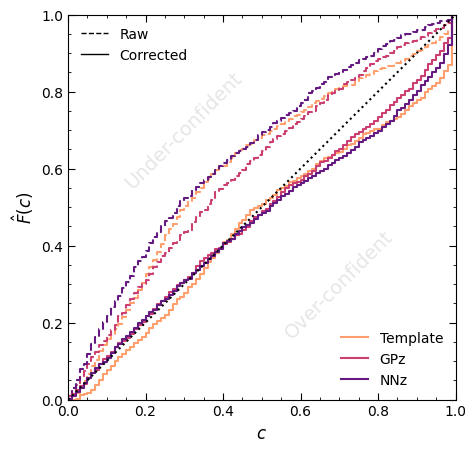

In [ ]:
from astropy.modeling.models import Gaussian1D
from astropy.convolution import convolve, Box1DKernel, Trapezoid1DKernel
from astropy.cosmology import FlatLambdaCDM
cos = FlatLambdaCDM(H0=70, Om0=0.3)

def HBpz(pzarr, zgrid, pzbad, beta=2., fbad_min=0.05, fbad_max=0.15, nbad = 6):
    fbad_range = np.linspace(fbad_min, fbad_max, nbad)
    pzarr_fbad = np.zeros((pzarr.shape[1], pzarr.shape[2], len(fbad_range)))

    for f, fbad in enumerate(fbad_range):
        #print fbad
        pzb = (fbad*pzbad) + (pzarr*(1-fbad))
        pzarr_fbad[:, :, f] = np.exp(np.sum(np.log(pzb)/beta, axis=0))


    pzarr_hb = np.trapezoid(pzarr_fbad, fbad_range, axis=2)
    pzarr_hb /= np.trapezoid(pzarr_hb, zgrid, axis=1)[:, None]
    return pzarr_hb

cols = plt.cm.magma_r([0.2, 0.45, 0.7, 1.0])

kern = Trapezoid1DKernel(1)

pzarr_temp_raw = np.exp(-0.5*(pz.chi2_fit[test_sample]))
pzarr_temp_raw /= np.trapezoid(pzarr_temp_raw, pz.zgrid, axis=1)[:, None]

pzarr_temp = np.exp(-0.5*(pz.chi2_fit[test_sample]))**(1/0.35)
pzarr_temp /= np.trapezoid(pzarr_temp, pz.zgrid, axis=1)[:, None]

pzarr_gpz_raw = np.array([Gaussian1D(mean=row['value'], stddev=row['uncertainty'])(pz.zgrid) for row in gpz_cat])
pzarr_gpz_raw /= np.trapezoid(pzarr_gpz_raw, pz.zgrid, axis=1)[:, None]

pzarr_gpz = np.array([Gaussian1D(mean=row['value'], stddev=0.66*row['uncertainty'])(pz.zgrid) for row in gpz_cat])
pzarr_gpz /= np.trapezoid(pzarr_gpz, pz.zgrid, axis=1)[:, None]

pzarr_nnz = pzarr_nnz_raw**(1/0.3) 
pzarr_nnz /= np.trapezoid(pzarr_nnz, pz.zgrid, axis=1)[:, None]

# pzarr_hyb = np.exp(np.nansum(np.log(np.array([pzarr_temp, pzarr_gpz, pzarr_nnz]))/2, axis=0))
# pzarr_hyb /= np.trapezoid(pzarr_hyb, pz.zgrid, axis=1)[:, None]


zspec = pz.ZSPEC[test_sample]
ci_temp_raw, cibins = calc_ci_dist(pzarr_temp_raw[st2], pz.zgrid, zspec[st2])
ci_gpz_raw, cibins = calc_ci_dist(pzarr_gpz_raw[st2], pz.zgrid, zspec[st2])
ci_nnz_raw, cibins = calc_ci_dist(pzarr_nnz_raw[st2], pz.zgrid, zspec[st2])

ci_temp, cibins = calc_ci_dist(pzarr_temp[st2], pz.zgrid, zspec[st2])
ci_gpz, cibins = calc_ci_dist(pzarr_gpz[st2], pz.zgrid, zspec[st2])
ci_nnz, cibins = calc_ci_dist(pzarr_nnz[st2], pz.zgrid, zspec[st2])

#ci_hyb, cibins = calc_ci_dist(pzarr_hyb, pz.zgrid, zspec)

Fig, Ax = plt.subplots(1,1, figsize=(5,5))

Ax.step(cibins, ci_temp_raw, where='mid', color=cols[0], ls='--')
Ax.step(cibins, ci_gpz_raw, where='mid', color=cols[1], ls='--')
Ax.step(cibins, ci_nnz_raw, where='mid', color=cols[2], ls='--')

Ax.step(cibins, ci_temp, where='mid', label='Template', color=cols[0])
Ax.step(cibins, ci_gpz, where='mid', label='GPz', color=cols[1])
Ax.step(cibins, ci_nnz, where='mid', label='NNz', color=cols[2])
#Ax.step(cibins, ci_hyb, where='mid', label='Consensus', color=cols[3])

Ax.plot([-1, -1], [-1, -1], 'k--', lw=1, label='Raw')
Ax.plot([-1, -1], [-1, -1], 'k', lw=1, label='Corrected')

handles, labels = Ax.get_legend_handles_labels()
leg = Ax.legend(handles[:-2], labels[:-2], loc='lower right', frameon=False, fontsize=10)

leg2 = Ax.legend(handles[-2:], labels[-2:], loc='upper left', frameon=False, fontsize=10)
Ax.add_artist(leg)

#leg = Ax.legend(frameon=False)
Ax.plot([0, 1], [0, 1], 'k:')
Ax.set_xlim([0, 1])
Ax.set_ylim([0, 1])
Ax.set_xlabel('$c$', size=12)
Ax.set_ylabel('$\^{F}(c)$', size=12)
Ax.text(0.7, 0.3, 'Over-confident', rotation=45,
        ha='center', va='center', transform=Ax.transAxes, size=14, color='0.5', zorder=1, alpha=0.2)
Ax.text(0.3, 0.7, 'Under-confident', rotation=45,
        ha='center', va='center', transform=Ax.transAxes, size=14, color='0.5', zorder=1, alpha=0.2)

Fig.savefig('figures/photoz_ci_dists.pdf', format='pdf', bbox_inches='tight')

---

## Part 7: P(z) Calibration & Confidence Intervals

### The Overconfidence Problem

Machine learning photo-z methods typically produce **overconfident P(z) distributions**:
- Predicted uncertainties are too narrow
- True redshifts fall outside 68% confidence intervals > 68% of the time
- Leads to underestimated systematic errors in cosmological analyses

### Calibration via P(z) Transformation

We calibrate P(z) distributions using:

```python
P(z)_calibrated = [P(z)_raw]^(1/β)
```

where β < 1 broadens the distribution. Optimal β values determined empirically:
- **GPz**: β = 0.66 (moderate overconfidence)
- **EAZY**: β = 0.35 (severe overconfidence from template discreteness)
- **NNz**: β = 0.30 (most overconfident due to limited neighbors)

### HPD Confidence Intervals

We use **Highest Posterior Density (HPD)** intervals rather than percentile-based intervals:

1. Find probability threshold where 80% of P(z) area is above threshold
2. Integrate over all redshift ranges exceeding this threshold
3. Provides tightest possible interval containing 80% probability

This approach naturally handles **multi-modal P(z)** distributions common at high-z.

### Calibration Diagnostics

**PIT (Probability Integral Transform)** histogram:
- Plot cumulative probability at true redshift: F(z_spec)
- Perfect calibration → uniform distribution [0,1]
- Over-confident → U-shaped distribution
- Under-confident → dome-shaped distribution

**CI Coverage Plot**:
- X-axis: Confidence interval c (0 to 1)
- Y-axis: Fraction of true redshifts within c-confidence region
- Perfect calibration → diagonal line
- Above diagonal → overconfident
- Below diagonal → underconfident

In [ ]:
# pzbad = cos.differential_comoving_volume(pz.zgrid).value -- Comoving Volume Prior
# pzbad /= np.trapezoid(pzbad, pz.zgrid)

pzbad = np.ones_like(pz.zgrid) # Flat prior
pzbad /= np.trapezoid(pzbad, pz.zgrid)

pzarr_combs = [np.array([pzarr_temp, pzarr_gpz]),
               np.array([pzarr_temp, pzarr_nnz]),
               np.array([pzarr_temp, pzarr_gpz, pzarr_nnz])]

pzarr_hyb = []

betas = [1.5, 1.7, 2.1]

for i, pzarr in enumerate(pzarr_combs):    
    pzh = HBpz(pzarr, pz.zgrid, pzbad, beta=betas[i], fbad_min=0, fbad_max=0.10, nbad=10)
    pzh /= np.trapezoid(pzh, pz.zgrid, axis=1)[:, None]
    pzarr_hyb.append(pzh)

pzarr_hyb = np.array(pzarr_hyb)


---

## Part 8: Hierarchical Bayesian Consensus Photo-z

### Why Combine Multiple Methods?

Each photo-z method has complementary strengths and weaknesses:

| Method | Strengths | Weaknesses |
|--------|-----------|------------|
| **GPz** | Non-parametric, learns from data | Requires dense training coverage |
| **EAZY** | Physically motivated, handles IGM | Limited by template library |
| **NNz** | Local adaptivity, model-free | Fails for novel populations |

**Consensus approach** leverages all methods to produce more robust estimates.

### Hierarchical Bayesian Combination

Rather than simple averaging, we use **hierarchical Bayesian combination**:

```python
P(z|D) = ∫ P(z|D,f_bad) P(f_bad) df_bad
```

where:
- `f_bad` = catastrophic outlier fraction [0.05, 0.15]
- Accounts for possibility that any method can fail catastrophically
- Marginalizing over `f_bad` produces robust final P(z)

### Implementation

For each object:
1. Combine calibrated P(z) from all three methods
2. Add "bad" prior (flat or comoving volume)
3. Mix: `P_combined = (1-f_bad) × P_methods + f_bad × P_bad`
4. Integrate over grid of f_bad values
5. Normalize final P(z)

### Bad Prior Options

**Flat prior** (conservative):
```python
P_bad(z) = constant  # Uniform over redshift range
```

**Comoving volume prior** (informed):
```python
P_bad(z) ∝ dV_c/dz  # Proportional to volume element
```

The comoving volume prior is more realistic for truly unconstrained cases (reflecting survey volume selection).

### Benefits

- **Reduced scatter**: Typically 10-30% improvement over single methods
- **Lower outlier fraction**: Catastrophic failures minimized
- **Better high-z performance**: Complementary information breaks degeneracies
- **Robust uncertainties**: Proper accounting of failure modes

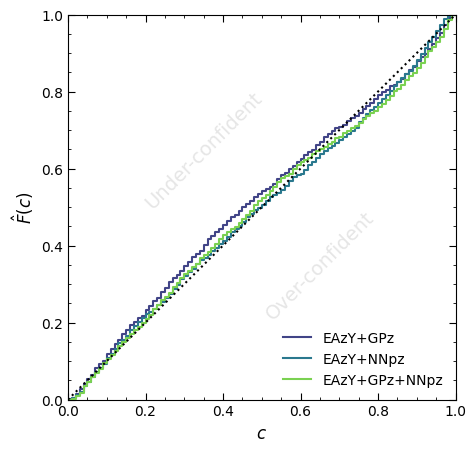

In [50]:
Fig, Ax = plt.subplots(1,1, figsize=(5,5))

cols = plt.cm.viridis([0.2, 0.4, 0.8])

labels = ['EAzY+GPz', 'EAzY+NNpz', 'EAzY+GPz+NNpz']

for i, pzh in enumerate(pzarr_hyb):
    ci_hyb_raw, cibins = calc_ci_dist(pzh, pz.zgrid, zspec)

    Ax.step(cibins, ci_hyb_raw, where='mid', label=labels[i], color=cols[i])


# handles, labels = Ax.get_legend_handles_labels()
# leg = Ax.legend(handles[:-2], labels[:-2], loc='lower right', frameon=False, fontsize=10)

# leg2 = Ax.legend(handles[-2:], labels[-2:], loc='upper left', frameon=False, fontsize=10)
# Ax.add_artist(leg)

leg = Ax.legend(frameon=False, loc='lower right', fontsize=10)

#leg = Ax.legend(frameon=False)
Ax.plot([0, 1], [0, 1], 'k:')
Ax.set_xlim([0, 1])
Ax.set_ylim([0, 1])
Ax.set_xlabel('$c$', size=12)
Ax.set_ylabel('$\^{F}(c)$', size=12)

Ax.text(0.65, 0.35, 'Over-confident', rotation=45,
        ha='center', va='center', transform=Ax.transAxes, size=14, color='0.5', zorder=1, alpha=0.2)
Ax.text(0.35, 0.65, 'Under-confident', rotation=45,
        ha='center', va='center', transform=Ax.transAxes, size=14, color='0.5', zorder=1, alpha=0.2)


Fig.savefig('figures/photoz_ci_dists_consensus.pdf', format='pdf', bbox_inches='tight')

### Visualizing Method Comparison

The following diagnostic plots compare individual methods and consensus results:

**z_phot vs z_spec scatter plot**:
- Points: Individual galaxies
- Error bars: Photo-z uncertainties
- Dashed line: Perfect agreement (y=x)
- Dotted lines: ±15% outlier threshold [(1+z) × 0.15]
- Log(1+z) scaling: Emphasizes high-redshift regime

**Performance metrics**:
- σ_NMAD: Overall scatter
- OLF₀.₁₅: Catastrophic outlier fraction
- Reported for magnitude-limited sample (m_F444W < 27.5)
- Separately for high-z subsample (z > 2)

**Color-coding**: 
- Different methods shown in different colors
- Transparency indicates uncertainty magnitude
- Outliers (outside dotted lines) visually identifiable

In [37]:
pzcat_temp = pz_to_catalog(pzarr_temp, pz.zgrid, pz.cat[test_sample])
pzcat_gpz = pz_to_catalog(pzarr_gpz, pz.zgrid, pz.cat[test_sample])
pzcat_nnz = pz_to_catalog(pzarr_nnz, pz.zgrid, pz.cat[test_sample])
pzcat_hyb = [pz_to_catalog(pzh, pz.zgrid, pz.cat[test_sample]) for pzh in pzarr_hyb]

In [38]:
multi_modal = (pzcat_temp['z2_median'] > 0).sum() / len(pzcat_temp) * 100
print(f'Multi-modal fraction: {multi_modal:.2f}%')

Multi-modal fraction: 54.88%


Confidence fraction for EAzY: 95.70%
Confidence fraction for GPz: 65.22%
Confidence fraction for NNpz: 87.25%


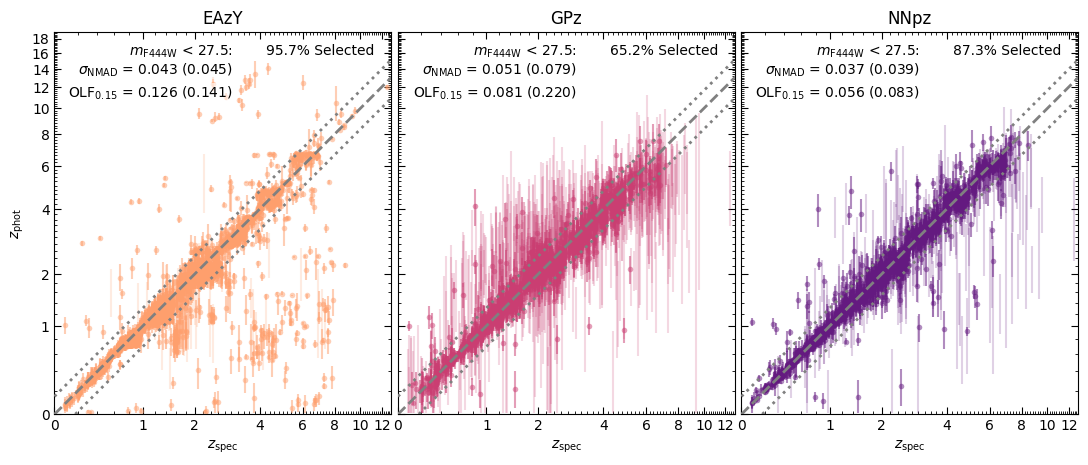

In [40]:
Fig, Ax = plt.subplots(1, 3, figsize=(11, 5), sharey=True)

cols = plt.cm.magma_r([0.2, 0.45, 0.7, 1.0])

labels = ['EAzY', 'GPz', 'NNpz', 'Consensus']

for j, pzc in enumerate([pzcat_temp, pzcat_gpz, pzcat_nnz]):
    ax = Ax[j]
    
    conf = ((pzc['z1_max'] - pzc['z1_min'])/(1+pzc['z1_median']) < 0.3)
    conf_frac = conf.sum() / len(pzc) * 100
    print(f'Confidence fraction for {labels[j]}: {conf_frac:.2f}%')
    
    pzcc = pzc[conf]
    pzcn = pzc[~conf]

    ax.set_aspect('equal')
    ax.errorbar(pzcn['z_spec'], pzcn['z1_median'], 
            yerr=[np.maximum(pzcn['z1_median']-pzcn['z1_min'], 0.01),
                    np.maximum(pzcn['z1_max']-pzcn['z1_median'], 0.01)],
            mew=0,  mfc='none',
            fmt='o', ms=4, color=cols[j], ecolor=cols[j], alpha=0.2)

    ax.errorbar(pzcc['z_spec'], pzcc['z1_median'], 
                yerr=[np.maximum(pzcc['z1_median']-pzcc['z1_min'], 0.01),
                      np.maximum(pzcc['z1_max']-pzcc['z1_median'], 0.01)],
                mew=0, 
                fmt='o', ms=4, color=cols[j], ecolor=cols[j], alpha=0.5)
    ax.set_xlim([0, 13])
    ax.set_ylim([0, 19])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))

    mcut = (gpz_cat['lupt_f444w'] < 27.5)
    stats_simple = calcStats(pzc['z_spec'][mcut*conf], pzc['z1_median'][mcut*conf])
    stats_all = calcStats(pzc['z_spec'][mcut], pzc['z1_median'][mcut])

    zcut = (gpz_cat['z_spec'] > 3)
    stats_z = calcStats(pzc['z_spec'][zcut*mcut*conf], pzc['z1_median'][zcut*mcut*conf])

    sigma = r'$\sigma_{\rm{NMAD}}$'
    olf = r'OLF$_{0.15}$'

    ax.text(0.53, 0.94, r'$m_{\rm{F444W}}$ < 27.5:', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))
    ax.text(0.53, 0.89, f'{sigma} = {stats_simple[0]:.3f} ({stats_all[0]:.3f})', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))
    ax.text(0.53, 0.83, f'{olf} = {stats_simple[1]:.3f} ({stats_all[1]:.3f})', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

    ax.text(0.95, 0.94, f'{conf_frac:.1f}% Selected', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

#     ax.text(0.27, 0.85, r'& $z > 3$:', ha='right', transform=ax.transAxes)
#     ax.text(0.28, 0.85, f'{sigma} = {stats_z[0]:.3f}', ha='left', transform=ax.transAxes)
#     ax.text(0.28, 0.8, f'{olf} = {stats_z[1]:.3f}', ha='left', transform=ax.transAxes)

    ax.set_xticks([0, 1, 2,  4, 6, 8, 10, 12])
    ax.set_yticks([0, 1, 2,  4, 6, 8, 10, 12, 14, 16, 18])
    
    zrange = np.linspace(0, 15, 100)
    ax.plot([0, 14], [0, 14], '--', color='0.5', lw=2, zorder=100)
    ax.plot(zrange, zrange+(0.15*(1+zrange)), ':', color='0.5', lw=2, zorder=100)
    ax.plot(zrange, zrange-(0.15*(1+zrange)), ':', color='0.5', lw=2, zorder=100)

    ax.set_xlabel(r'$z_{\rm{spec}}$')
    ax.set_ylabel(r'$z_{\rm{phot}}$')
    #Ax.set_title('6 Filters (PANORAMIC) + Flux radius')

    if j > 0:
        #ax.set_yticks([])
        ax.set_ylabel('')
        
    ax.set_title(labels[j])
    
Fig.tight_layout()
Fig.subplots_adjust(wspace=0.02)
Fig.savefig('figures/jwst_eazy_gpz_nnz_panoramic6_zspec_comp.pdf', format='pdf', bbox_inches='tight')

---

## Part 9: Multi-Modal P(z) Analysis

### Peak Detection in P(z)

Many high-redshift galaxies have **multi-modal P(z)** due to color degeneracies:
- Lyman break (z~0.5-1.5) vs Balmer/4000Å break (z~3-6)
- Dust-reddened low-z vs intrinsically red high-z
- Multiple template matches at different redshifts

### Peak Extraction Algorithm

The `get_peak_z()` function identifies all significant peaks:

1. **Find 80% HPD threshold**: Iteratively lower threshold until 80% of P(z) area retained
2. **Identify contiguous regions**: Find connected components above threshold
3. **Calculate peak properties**: For each peak compute:
   - `z_median`: Mean redshift weighted by P(z)
   - `z_min, z_max`: Boundaries of HPD region
   - `area`: Integrated probability (normalized to sum=1)
4. **Sort by area**: Primary peak = highest area, secondary = second highest

### Multi-Modality Fraction

```python
multi_modal_frac = Σ(P_secondary > 0.2) / N_total
```

Fraction of sources with significant (>20% probability) secondary peaks. Typically:
- ~5% at z < 1 (well-constrained colors)
- ~15-25% at 2 < z < 4 (break degeneracies)
- ~30%+ at z > 6 (sparse training data)

### Handling Multi-Modal Cases

**For science applications**:
- **Point estimates**: Use primary peak (z1_median)
- **Full P(z)**: Preserve all peaks for marginalization over photo-z uncertainty
- **Classification**: Flag multi-modal cases for spectroscopic follow-up priority

**Catalog columns**:
- `z_peak`: Global maximum of P(z)
- `z1_median, z1_min, z1_max, z1_area`: Primary peak
- `z2_median, z2_min, z2_max, z2_area`: Secondary peak (if present)
- Values of -99 indicate no peak found

Confidence fraction for EAzY+GPz: 93.65%
Multi-modal fraction: 36.46%
Confidence fraction for EAzY+NNpz: 95.44%
Multi-modal fraction: 27.12%
Confidence fraction for EAzY+GPz+NNpz: 93.60%
Multi-modal fraction: 24.08%


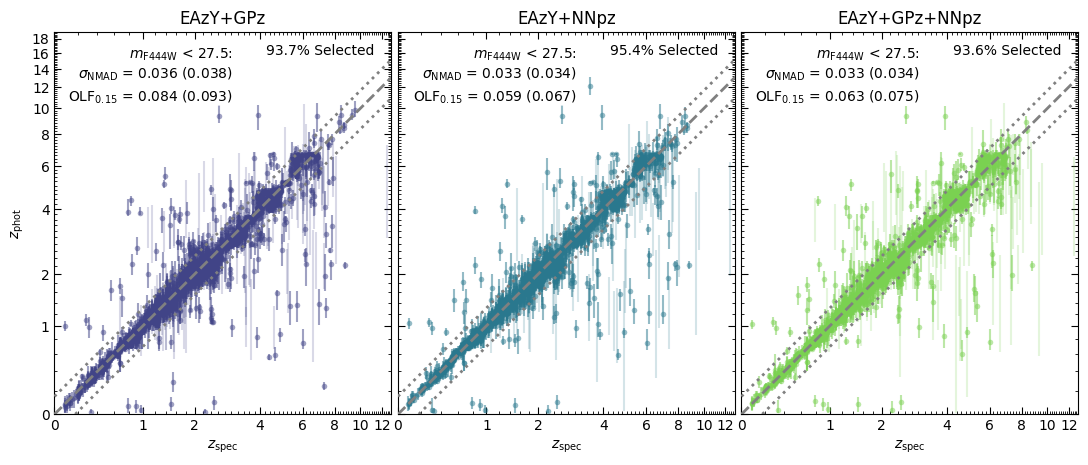

In [41]:
Fig, Ax = plt.subplots(1, 3, figsize=(11, 5), sharey=True)

cols = plt.cm.viridis([0.2, 0.4, 0.8])

labels = ['EAzY+GPz', 'EAzY+NNpz', 'EAzY+GPz+NNpz']

for j, pzc in enumerate(pzcat_hyb):
    ax = Ax[j]

    conf = ((pzc['z1_max'] - pzc['z1_min'])/(1+pzc['z1_median']) < 0.3)
    conf_frac = conf.sum() / len(pzc) * 100
    print(f'Confidence fraction for {labels[j]}: {conf_frac:.2f}%')
    
    multi_modal = (pzc['z2_median'] > 0).sum() / len(pzc) * 100
    print(f'Multi-modal fraction: {multi_modal:.2f}%')

    pzcc = pzc[conf]
    pzcn = pzc[~conf]

    ax.set_aspect('equal')
    ax.errorbar(pzcn['z_spec'], pzcn['z1_median'], 
            yerr=[np.maximum(pzcn['z1_median']-pzcn['z1_min'], 0.01),
                    np.maximum(pzcn['z1_max']-pzcn['z1_median'], 0.01)],
            mew=0,  mfc='none',
            fmt='o', ms=4, color=cols[j], ecolor=cols[j], alpha=0.2)
    
    ax.set_aspect('equal')
    ax.errorbar(pzcc['z_spec'], pzcc['z1_median'], 
                yerr=[np.maximum(pzcc['z1_median']-pzcc['z1_min'], 0.01),
                      np.maximum(pzcc['z1_max']-pzcc['z1_median'], 0.01)],
                mew=0, 
                fmt='o', ms=4, color=cols[j], ecolor=cols[j], alpha=0.5)
    ax.set_xlim([0, 13])
    ax.set_ylim([0, 19])

    ax.set_yscale('function', functions=(forward, inverse))
    ax.set_xscale('function', functions=(forward, inverse))

    mcut = (gpz_cat['lupt_f444w'] < 27.5)
    stats_simple = calcStats(pzc['z_spec'][mcut*conf], pzc['z1_median'][mcut*conf])
    stats_all = calcStats(pzc['z_spec'][mcut], pzc['z1_median'][mcut])

    zcut = (gpz_cat['z_spec'] > 3)
    #stats_all = calcStats(pzc['z_spec'][zcut*mcut*conf], pzc['z1_median'][zcut*mcut*conf])

    sigma = r'$\sigma_{\rm{NMAD}}$'
    olf = r'OLF$_{0.15}$'

    ax.text(0.53, 0.93, r'$m_{\rm{F444W}}$ < 27.5:', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))
    ax.text(0.53, 0.88, f'{sigma} = {stats_simple[0]:.3f} ({stats_all[0]:.3f})', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))
    ax.text(0.53, 0.82, f'{olf} = {stats_simple[1]:.3f} ({stats_all[1]:.3f})', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

    ax.text(0.95, 0.94, f'{conf_frac:.1f}% Selected', ha='right', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=0.5))

#     ax.text(0.27, 0.85, r'& $z > 3$:', ha='right', transform=ax.transAxes)
#     ax.text(0.28, 0.85, f'{sigma} = {stats_z[0]:.3f}', ha='left', transform=ax.transAxes)
#     ax.text(0.28, 0.8, f'{olf} = {stats_z[1]:.3f}', ha='left', transform=ax.transAxes)

    ax.set_xticks([0, 1, 2,  4, 6, 8, 10, 12])
    ax.set_yticks([0, 1, 2,  4, 6, 8, 10, 12, 14, 16, 18])
    
    zrange = np.linspace(0, 15, 100)
    ax.plot([0, 14], [0, 14], '--', color='0.5', lw=2, zorder=100)
    ax.plot(zrange, zrange+(0.15*(1+zrange)), ':', color='0.5', lw=2, zorder=100)
    ax.plot(zrange, zrange-(0.15*(1+zrange)), ':', color='0.5', lw=2, zorder=100)

    ax.set_xlabel(r'$z_{\rm{spec}}$')
    ax.set_ylabel(r'$z_{\rm{phot}}$')
    #Ax.set_title('6 Filters (PANORAMIC) + Flux radius')

    if j > 0:
        #ax.set_yticks([])
        ax.set_ylabel('')
        
    ax.set_title(labels[j])
    
Fig.tight_layout()
Fig.subplots_adjust(wspace=0.02)
Fig.savefig('figures/jwst_hybdrid_panoramic6_zspec_comp.pdf', format='pdf', bbox_inches='tight')

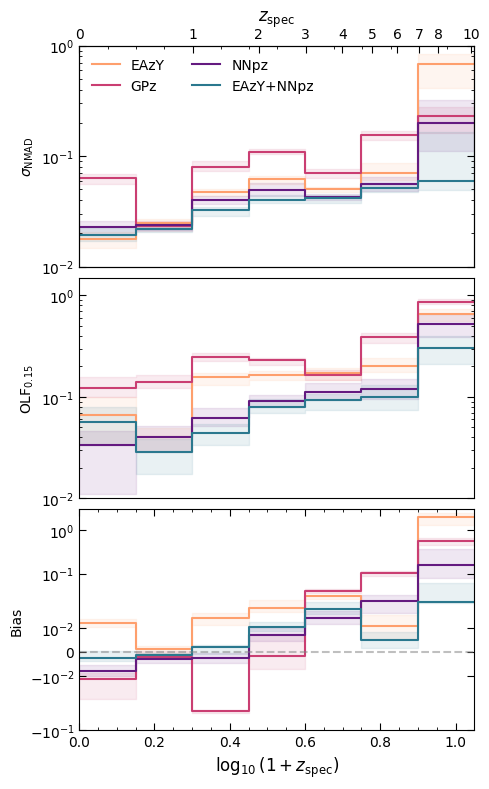

In [43]:
lzbins = np.linspace(0, 1.05, 8)
lzmids = 0.5*(lzbins[1:] + lzbins[:-1])
lzmids = np.concatenate([[0], lzmids, [1.05]])

stats = []

for iz, lzmin in enumerate(lzbins[:-1]):
    zst = []
    for j, pzc in enumerate([pzcat_temp, pzcat_gpz, pzcat_nnz, pzcat_hyb[1]]):
        conf = (gpz_cat['lupt_f444w'] < 27.5) # * ((pzc['z1_max'] - pzc['z1_min'])/(1+pzc['z1_median']) < 0.3)
        zcut = (np.log10(1+pzc['z_spec']) > lzmin)*(np.log10(1+pzc['z_spec']) < lzbins[iz+1])
        
        boot_samples = np.array(bootstrap(np.arange((zcut*conf).sum()), bootnum=100), dtype=np.int32)
        
        bst = []
        for s in boot_samples:
        
            bst.append(calcStats(pzc['z_spec'][zcut*conf][s], pzc['z1_median'][zcut*conf][s]))
        
        zst.append(bst)   
        
    stats.append(zst)
    
stats = np.array(stats)

stats16, stats50, stats84 = np.percentile(stats, [16, 50, 84], axis=2)

stats16_plot = np.concatenate([stats16[0][None,:], stats16, stats16[-1][None,:]], axis=0)
stats50_plot = np.concatenate([stats50[0][None,:], stats50, stats50[-1][None,:]], axis=0)
stats84_plot = np.concatenate([stats84[0][None,:], stats84, stats84[-1][None,:]], axis=0)

cols = plt.cm.magma_r([0.2, 0.45, 0.7])
cols2 = plt.cm.viridis([0.2, 0.4, 0.8])

ccols = np.concatenate([cols, np.array(cols2[1], ndmin=2)], axis=0)

labels = ['EAzY', 'GPz', 'NNpz', 'EAzY+NNpz'] # +GPz

Fig, Ax = plt.subplots(3, 1, figsize=(5, 8.))

for k, col in enumerate(ccols):
    Ax[0].fill_between(lzmids, stats84_plot[:, k, 0], stats16_plot[:, k, 0],
                       step='mid', color=col, alpha=0.1)
    Ax[1].fill_between(lzmids, stats84_plot[:, k, 1], stats16_plot[:, k, 1],
                       step='mid', color=col, alpha=0.1)
    Ax[2].fill_between(lzmids, stats84_plot[:, k, -1], stats16_plot[:, k, -1],
                       step='mid', color=col, alpha=0.1)

    Ax[0].step(lzmids, stats50_plot[:, k, 0], where='mid', color=col, label=labels[k])
    Ax[1].step(lzmids, stats50_plot[:, k, 1], where='mid', color=col, label=labels[k])
    Ax[2].step(lzmids, stats50_plot[:, k, -1], where='mid', color=col, label=labels[k])

Ax[0].set_ylim([0.01, 1])
Ax[0].set_xticks([])
Ax[1].set_xticks([])
Ax[0].set_yscale('log')
Ax[1].set_yscale('log')
Ax[1].set_ylim([0.01, 1.5])

Leg = Ax[0].legend(loc='upper left', frameon=False, ncol=2)

Ax[2].set_yscale('symlog', linthresh=0.02)
Ax[2].set_ylim([-0.1, 3])
Ax[2].plot(lzbins, np.zeros_like(lzbins), '--', color='0.5', alpha=0.5)
Ax[2].set_xlabel(r'$\log_{10}(1+z_{\rm{spec}})$', size=12)


Ax[0].set_ylabel(r'$\sigma_{\rm{NMAD}}$')
Ax[1].set_ylabel(r'OLF$_{0.15}$')
Ax[2].set_ylabel(r'Bias')
    
for ax in Ax:
    ax.set_xlim([0, 1.05])

tw = Ax[0].twiny()
tw.set_xlim([0, 1.05])
tw.set_yscale('log')
tw.set_ylim([0.01, 1])
tw.set_xticks(np.log10(1+np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 10])))
tw.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 10])
tw.set_xlabel(r'$z_{\rm{spec}}$', size=12)
    
Fig.tight_layout()
Fig.subplots_adjust(hspace=0.05)
Fig.savefig('figures/stats_vs_z_combined.pdf', format='pdf', bbox_inches='tight')

### Redshift-Dependent Performance

Photo-z accuracy varies systematically with redshift due to:

**Physical effects**:
- **z < 1**: Rich spectral features (4000Å break, H/K lines) → excellent constraints
- **1 < z < 3**: Balmer break in NIR → good but degeneracies emerge
- **3 < z < 7**: Lyman break observable → strong constraints return
- **z > 7**: Lyman break moves to F115W, fewer features → degraded performance

**Sample effects**:
- **Training density**: Sparse at z > 5 (few spec-z)
- **Magnitude limits**: Faint high-z galaxies → lower S/N
- **Selection biases**: Bright, blue galaxies over-represented in training

**Plotting conventions**:
- Binned statistics show trends
- Error bars from bootstrap resampling
- Separate metrics for bright (m_F444W < 27.5) and faint samples

In [44]:
def crps(pzarr, zgrid, zspec):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a given photo-z array.
    
    Parameters:
    pzarr : array-like
        The photo-z probability distribution array.
    zgrid : array-like
        The redshift grid.
    zspec : array-like
        The spectroscopic redshift values.
        
    Returns:
    crps : float
        The CRPS value.
    """
    cdf_pz = np.cumsum(pzarr, axis=1)
    cdf_pz /= cdf_pz[:, -1][:, None]  # Normalize the CDF

    cdf_spec = np.zeros_like(cdf_pz)

    for i, z in enumerate(zspec):
        if z < zgrid[0] or z > zgrid[-1]:
            continue
        cdf_spec[i][zgrid > z] = 1.0

    crps = np.trapezoid((cdf_spec-cdf_pz)**2, zgrid, axis=1)
    return crps

In [45]:
crps_temp = crps(pzarr_temp, pz.zgrid, pz.ZSPEC[test_sample])
crps_gpz = crps(pzarr_gpz, pz.zgrid, pz.ZSPEC[test_sample])
crps_nnz = crps(pzarr_nnz, pz.zgrid, pz.ZSPEC[test_sample])
crps_hyb = [crps(pzh, pz.zgrid, pz.ZSPEC[test_sample]) for pzh in pzarr_hyb]
crps_hyb = np.array(crps_hyb)

CRPS EAzY: nan +/- nan
CRPS GPz: 0.349 +/- 0.578
CRPS NNpz: 0.238 +/- 0.576
CRPS EAzY+GPz: nan +/- nan
CRPS EAzY+NNpz: nan +/- nan
CRPS EAzY+GPz+NNpz: nan +/- nan


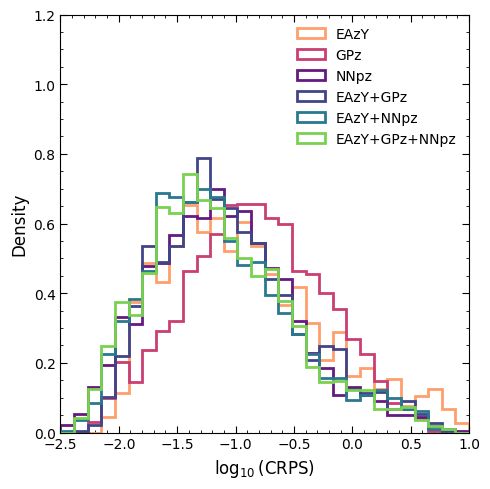

In [46]:
Fig, Ax = plt.subplots(1, 1, figsize=(5, 5))
cols = plt.cm.viridis([0.2, 0.4, 0.8])
labels = ['EAzY', 'GPz', 'NNpz']

cols = plt.cm.magma_r([0.2, 0.45, 0.7, 1.0])

Ax.hist(np.log10(crps_temp), bins=30, density=True, histtype='step', color=cols[0], label=labels[0], lw=2, range=(-2.5, 1))
Ax.hist(np.log10(crps_gpz), bins=30, density=True, histtype='step', color=cols[1], label=labels[1], lw=2, range=(-2.5, 1))
Ax.hist(np.log10(crps_nnz), bins=30, density=True, histtype='step', color=cols[2], label=labels[2], lw=2, range=(-2.5, 1))

for i, c in enumerate([crps_temp, crps_gpz, crps_nnz]):
    print(f'CRPS {labels[i]}: {np.mean(c):.3f} +/- {np.std(c):.3f}')

cols2 = plt.cm.viridis([0.2, 0.4, 0.8])
labels2 = ['EAzY+GPz', 'EAzY+NNpz', 'EAzY+GPz+NNpz']

Ax.hist(np.log10(crps_hyb[0]), bins=30, density=True, histtype='step', color=cols2[0], label=labels2[0], lw=2, range=(-2.5, 1))
Ax.hist(np.log10(crps_hyb[1]), bins=30, density=True, histtype='step', color=cols2[1], label=labels2[1], lw=2, range=(-2.5, 1))
Ax.hist(np.log10(crps_hyb[2]), bins=30, density=True, histtype='step', color=cols2[2], label=labels2[2], lw=2, range=(-2.5, 1))

for i, c in enumerate(crps_hyb):
    print(f'CRPS {labels2[i]}: {np.mean(c):.3f} +/- {np.std(c):.3f}')
Ax.set_xlabel(r'$\log_{10}(\rm{CRPS})$', size=12)
Ax.set_ylabel('Density', size=12)
Ax.set_xlim([-2.5, 1])
Ax.set_ylim([0, 1.2])
Ax.legend(loc='upper right', frameon=False, fontsize=10)
Fig.tight_layout()

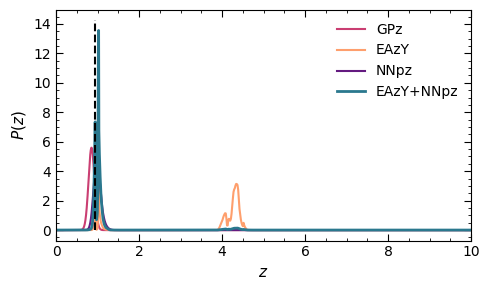

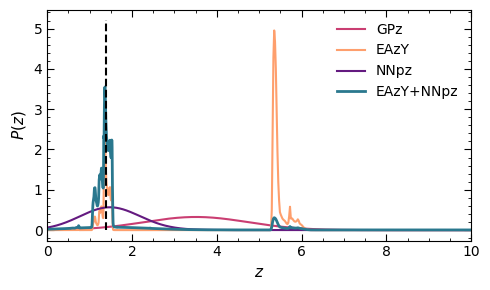

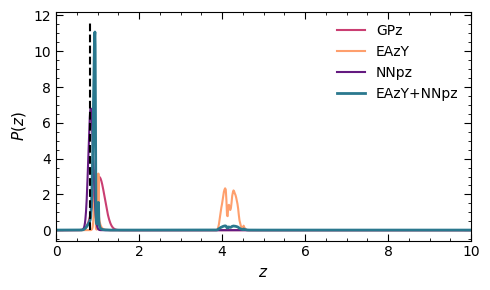

In [48]:
# Identify sources with high redshift in temp, low redshift in spec, and low redshift in hybrid
fail_mode1 = np.where((pzcat_temp['z1_median'] > 4) & # High redshift in temp
                      (pzcat_temp['z_spec'] < 2) & # Low spec redshift in temp
                      (pzcat_hyb[1]['z1_median'] < 2))[0] # Low redshift in hybrid

for i in fail_mode1:
    Fig, Ax = plt.subplots(1,1, figsize=(5, 3))
    Ax.plot(pz.zgrid, pzarr_gpz[i], color=cols[1], label=labels[1])
    #Ax.plot(pz.zgrid, pzarr_temp_raw[i], color=cols[1], ls='--')
    Ax.plot(pz.zgrid, pzarr_temp[i], color=cols[0], label=labels[0])
    Ax.plot(pz.zgrid, pzarr_nnz[i], color=cols[2], label=labels[2])
    Ax.plot(pz.zgrid, pzarr_hyb[1][i], color=cols2[1], label=labels2[1], lw=2)

    L = Ax.legend(loc='upper right', frameon=False)
    L.get_frame().set_edgecolor('1')

    _, ymax = Ax.get_ylim()

    Ax.set_xlim([0, 10])
    #Ax.set_ylim([0, 1.8])
    Ax.set_xlabel('$z$', size=11)
    Ax.set_ylabel('$P(z)$', size=11)
    Ax.vlines(pz.ZSPEC[test_sample][i], ymax=ymax, ymin=0, color='k', ls='--')

    Fig.tight_layout()
    Fig.savefig(f'figures/consensus_example_failmode1_{i+1}.pdf', format='pdf', bbox_inches='tight')


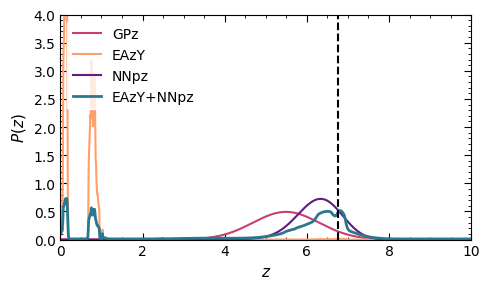

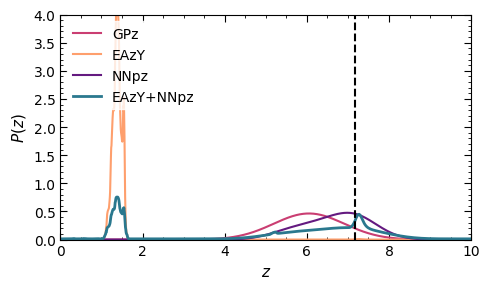

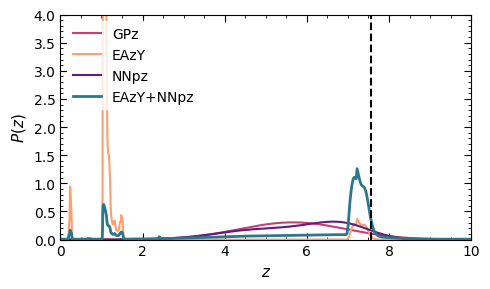

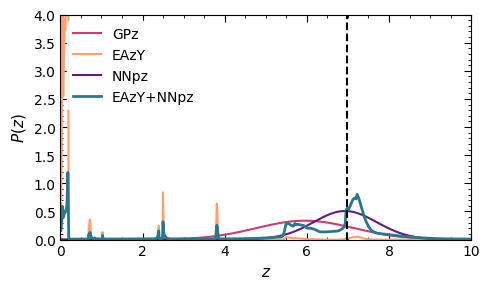

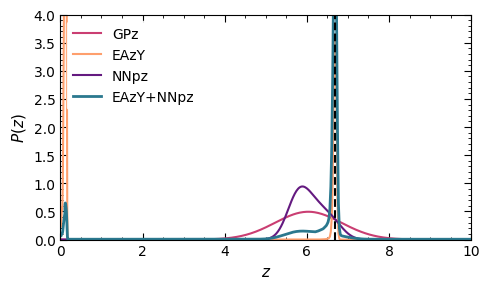

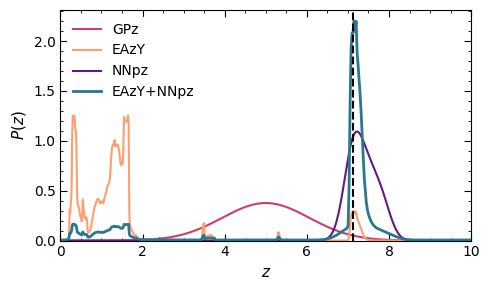

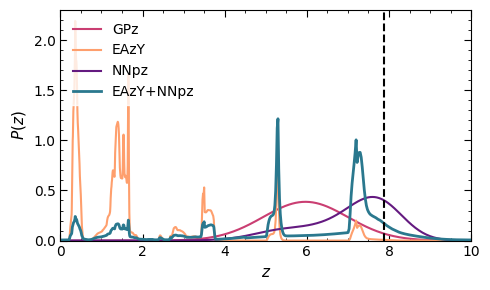

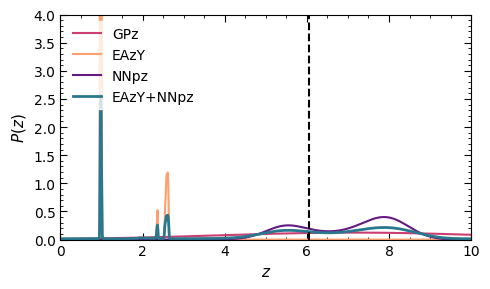

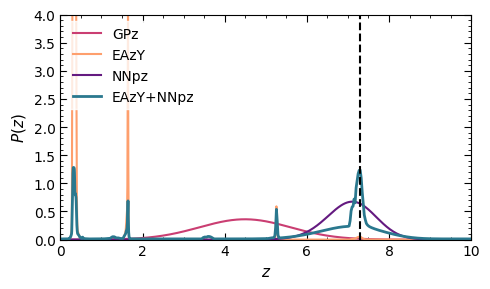

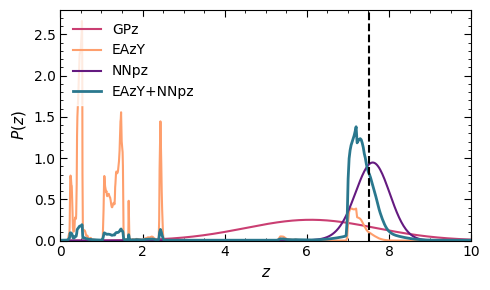

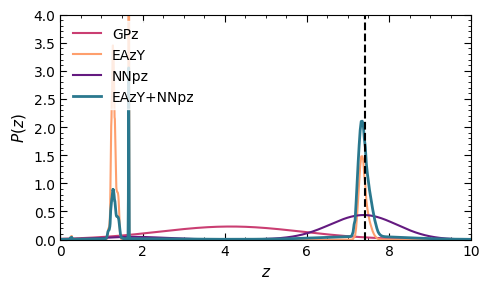

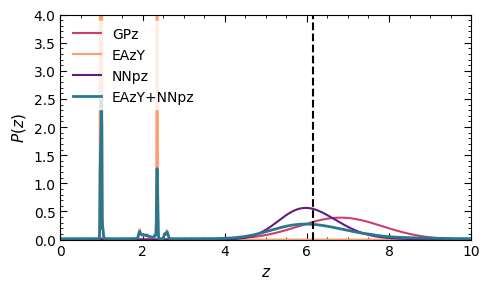

In [49]:
# Identify sources with low redshift in temp, high redshift in spec, and high redshift in hybrid
fail_mode2 = np.where((pzcat_temp['z1_median'] < 2) & # Low redshift in temp
                      (pzcat_temp['z_spec'] > 6) & # High spec redshift in temp
                      (pzcat_hyb[2]['z1_median'] > 6))[0] # High redshift in hybrid

for i in fail_mode2:
    Fig, Ax = plt.subplots(1,1, figsize=(5, 3))
    Ax.plot(pz.zgrid, pzarr_gpz[i], color=cols[1], label=labels[1])
    #Ax.plot(pz.zgrid, pzarr_temp_raw[i], color=cols[1], ls='--')
    Ax.plot(pz.zgrid, pzarr_temp[i], color=cols[0], label=labels[0])
    Ax.plot(pz.zgrid, pzarr_nnz[i], color=cols[2], label=labels[2])
    Ax.plot(pz.zgrid, pzarr_hyb[1][i], color=cols2[1], label=labels2[1], lw=2)

    L = Ax.legend(loc='upper left', frameon=True)
    L.get_frame().set_edgecolor('1')

    _, ymax = Ax.get_ylim()

    Ax.set_ylim([0, np.minimum(4, ymax)])
    Ax.set_xlim([0, 10])
    Ax.set_xlabel('$z$', size=11)
    Ax.set_ylabel('$P(z)$', size=11)
    Ax.vlines(pz.ZSPEC[test_sample][i], ymax=ymax, ymin=0, color='k', ls='--')

    Fig.tight_layout()
    Fig.savefig(f'figures/consensus_example_failmode2_{i+1}.pdf', format='pdf', bbox_inches='tight')

###### 

---

## Summary & Best Practices

### Key Takeaways

1. **Multi-method consensus outperforms individual methods** by 10-30% in scatter and outlier fraction

2. **P(z) calibration is essential** - raw ML predictions are systematically overconfident

3. **Training sample quality matters more than quantity** - prioritize high-grade spec-z over volume

4. **Morphological features improve high-z performance** - size information breaks degeneracies

5. **Multi-modal P(z) are common at z > 2** - preserve full distributions for science applications

### Recommended Workflow

For applying to new JWST fields:

1. Assemble multi-source spec-z training sample (CANDELS, NIRSpec, WFSS)
2. Cross-match to DJA photometry with 0.4" tolerance
3. Apply Galactic extinction correction using SFD maps
4. Transform to luptitudes with filter-specific softening
5. Train GPz with NUM_BF ~ 75 (optimize via validation set)
6. Run EAZY with appropriate template set and zero-points
7. Compute NNz with K=300 neighbors and chi-squared weighting
8. Calibrate individual P(z) using held-out validation sample
9. Combine via hierarchical Bayesian marginalization
10. Extract peaks and confidence intervals from final P(z)

### Output Products

Final catalogs should include:
- **Point estimates**: `z_phot` (primary peak median)
- **Uncertainties**: `z_min`, `z_max` (80% HPD intervals)
- **Full P(z)**: Arrays for downstream analyses requiring marginalization
- **Quality flags**: Multi-modal indicators, magnitude limits, method agreement
- **Individual method results**: For diagnostic purposes

### Performance Expectations

For JWST 6-band NIRCam photometry with ~1000 training spec-z:
- **σ_NMAD ~ 0.03-0.04** at z < 3, m < 27.5
- **σ_NMAD ~ 0.05-0.07** at 3 < z < 7
- **OLF₀.₁₅ ~ 5-8%** overall
- **Multi-modal fraction ~ 15%** at z > 2

### Limitations & Future Improvements

**Current limitations**:
- Breaks down at m_F444W > 28 (low S/N)
- Requires spectroscopic training at target redshifts
- Template libraries may not span full diversity

**Promising directions**:
- **Self-organizing maps** for automated outlier detection
- **Transfer learning** from HST to JWST
- **Bayesian neural networks** for improved uncertainty quantification
- **Simulation-based inference** to augment sparse training data